# Overview of Prototype

To help Tasty Bytes increase the number of high value customers and improve their revenue, our machine learning model aims to cluster Tasty Byte’s customers into high and low value customers so that Tasty Bytes would know from a business perspective, which customers to target. As each country has its own localised menu options, customers in different countries can have different behavioural patterns which might ultimately affect the machine learning model. Diving down into a specific country will also be more helpful for the business as they will be able to have a more comprehensive understanding of the specific market and customer segmentation within a specific country. 

Hence, our group decided to focus on Tasty Bytes customers in the United States (US). The reason for choosing to focus on US is because US has the greatest number of customers, highest number of order transactions, as well as the highest transactional value. This allows Tasty Bytes to prioritise the markets that have the potential for better business opportunities and revenue generation. 
We firstly calculated the RFM (recency, frequency, monetary value) for each customer and then used K-means clustering to cluster the customers into high and low value customers based on the RFM calculated and other factors such as demographics, etc. To assess and evaluate the quality, reliability and appropriateness of the clustering results and algorithm, we used silhouette coefficient.  

In order to prove that our model is of value to help Tasty Bytes hit the key performance indicator (KPI) that we have set previously, we built another machine learning model to do prediction based on the clustered customers dataset to help predict customer’s spending. This will help Tasty Bytes to see the direction of their future sales and plan their financial strategies accordingly. The model can also help them to identify customers who are at a risk of churn or reducing their engagement, help to identify potential upselling or cross-selling opportunities, and also offer customers with high predicted future monetary value exclusive loyalty program. 

# Table of Contents <a id="top"></a>
#### 1. [Loading of Datasets](#part1)
#### 2. [Data Exploration](#part2)
   - [2.1 Number of Customers by Country](#part2-1)
   - [2.2 Revenue Generated by Each Country](#part2-2)
   - [2.3 Number of Orders by Country](#part2-3)
   - [2.4 Cardinality Ratio](#part2-4)
   - [2.5 Missing value](#part2-5)
#### 3. [Data Preparation](#part3)
   - [3.1 Create dataframe](#part3-1)
   - [3.2 Null Value Treatment](#part3-2)
   - [3.3 Replacing values](#part3-3)
   - [3.4 Categorical encoding](#part3-4)
   - [3.5 Calculating customer's age](#part3-5)
#### 4. [Calculating RFM (Recency, Frequency & Monetary Value)](#part4)
   - [4.1 Calculation of Recency](#part4-1)
   - [4.2 Calculation of Frequency](#part4-2)
   - [4.3 Calculation of Monetary Value](#part4-3)
   - [4.4 Dataframe with RFM Calculation](#part4-4)
   - [4.5 Outliers Treatment](#part4-5)
#### 5. [Clustering Model](#part5)
   - [5.1 Baseline Model](#part5-1)
   - [5.2 Improvements to the model](#part5-2)
#### 6. [Prediction of Monetary Value](#part6)
   - [6.1 Data Preparation](#part6-1)
      - [6.1.1 Create dataframe](#part6-1-1)
      - [6.1.2 Calculating RFM](#part6-1-1)
      - [6.1.3 Feature Engineering](#part6-1-1)
   - [6.2 RFM Clustering](#part6-2)
      - [6.2.1 Recency](#part6-2-1)
      - [6.2.2 Frequency](#part6-2-2)
      - [6.2.3 Monetary](#part6-2-3)
      - [6.2.4 Creating Target Variable](#part6-2-4)
   - [6.3 Building Model](#part6-3)
   - [6.4 Comparison of Results](#part6-4)
   - [6.5 Measurement of Uplift](#part6-6)

## Importing packages & setting up connection

In [1]:
# Import Python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import sys
import cachetools
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt 
import seaborn as sns
import math

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col

# Clustering & Model
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Scalers
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# find the best combination of model hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# Getting Password,Username, Account
import getpass

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get account credentials from a json file
with open("account.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    #"role": "ACCOUNTADMIN",
    #"warehouse": "tasty_ds_wh",
    #"database": "NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE",
    #"schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## 1. Loading of Datasets <a id="part1"></a>

In [3]:
order_header_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.order_header")
customer_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_customer.customer_loyalty")
location_df = location_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.location")

In [4]:
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22477378    |97          |3713.0         |NULL           |NULL           |78881       |16:00:00            |23:00:00          |NULL             |2020-04-

In [5]:
customer_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

In [6]:
location_df.show()

----------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"PLACEKEY"           |"LOCATION"                     |"CITY"  |"REGION"  |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
----------------------------------------------------------------------------------------------------------------------------
|13190          |zzy-22m@53g-bsm-9vf  |Sabine Weber                   |Munich  |Bayern    |DE                  |Germany    |
|13192          |zzy-22m@53g-ddj-ndv  |getAway LiveQuest              |Munich  |Bayern    |DE                  |Germany    |
|4883           |zzy-222@53g-brb-b8v  |Uptown                         |Munich  |Bayern    |DE                  |Germany    |
|4994           |zzy-222@53g-df2-vs5  |SV Neu Perlach                 |Munich  |Bayern    |DE                  |Germany    |
|4928           |zzy-222@53g-bs2-99f  |Borstei Museum                 |Munich  |Bayern    |DE                  |Germany    |


### Dropping of null values in customer id

In [7]:
# Null Customer ID refers are non-members
order_header_df = order_header_df.na.drop(subset="CUSTOMER_ID")
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22477396    |97          |3713.0         |95165          |NULL           |78881       |16:00:00            |23:00:00          |NULL             |2020-04-

### Merging of locations with order transactions

In [8]:
orders = order_header_df.join(location_df, order_header_df.LOCATION_ID == location_df.LOCATION_ID,lsuffix = "", rsuffix = "LOCATION")
orders.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"LOCATION_IDLOCATION"  |"PLACEKEY"           |"LOCATION"                    |"CITY"  |"REGION"  |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 2. Data Exploration <a id="part2"></a>

### 2.1 Number of Customers by Country <a id="part2-2"></a>

In [9]:
no_cust_by_country = customer_df.group_by("COUNTRY").agg(F.count("CUSTOMER_ID").alias("NO_OF_CUST")).to_pandas()
no_cust_by_country.head()

,COUNTRY,NO_OF_CUST
0,Canada,28302
1,United States,46300
2,Spain,8516
3,Germany,15790
4,Sweden,6192


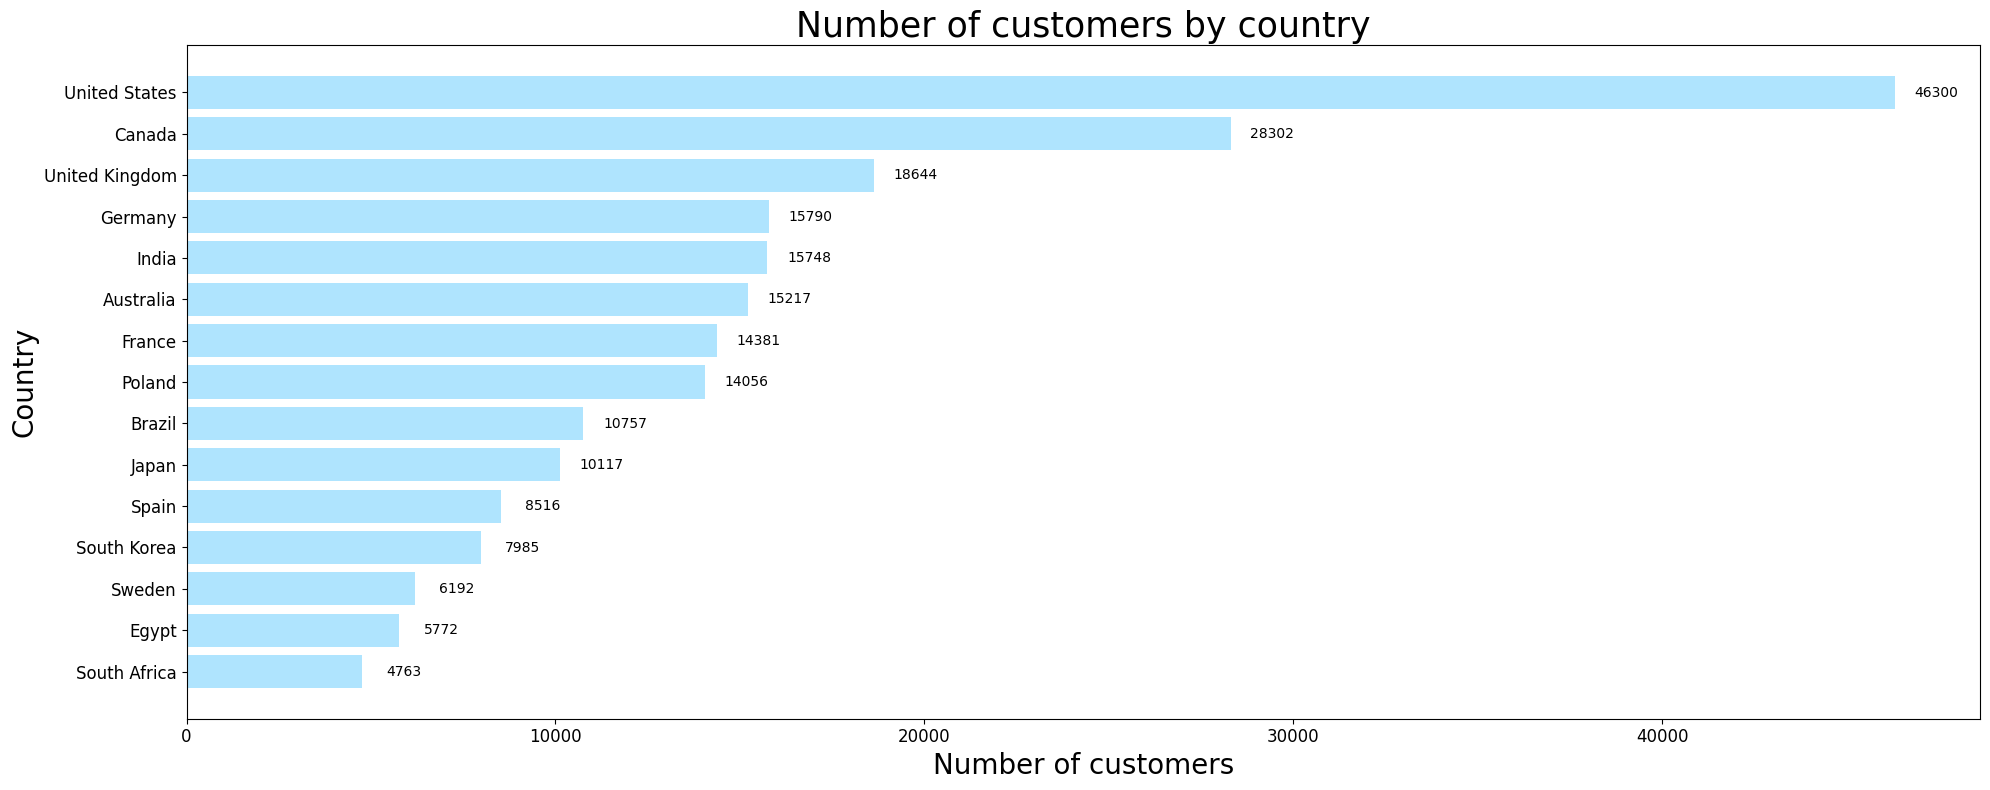

In [10]:
no_cust_by_country.sort_values(by='NO_OF_CUST', ascending=True, inplace=True) # Sort values in ascending order of customer
country_index = no_cust_by_country['COUNTRY'].tolist()
no_cust_values = no_cust_by_country['NO_OF_CUST'].tolist()

# Create a figure and subplot
fig, v1 = plt.subplots(figsize=(20,8))

# Create a horizontal bar chart 
v1.barh(country_index,no_cust_values, align = 'center', color='#AFE4FE') # align define the alignment of x-ticks

# Display data labels
for x,y in zip(no_cust_values ,country_index):

    label = x

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(30,-3), 
                 fontsize = 10,
                 ha='center') 

# State title of plot and the axes labels
v1.set_title('Number of customers by country', fontsize = 25)
v1.set_ylabel('Country',fontsize = 20)
v1.set_xlabel('Number of customers', fontsize = 20)

# Set font size of ticks on the x-axis and y-axis
v1.tick_params(labelsize = 12, axis ='both')

# Set tight layout for figure
fig.tight_layout()

# Display plot
plt.show()

### 2.2 Revenue Generated by Each Country <a id="part2-2"></a>

In [11]:
revenue_by_country = orders.group_by("COUNTRY").agg(F.sum("ORDER_TOTAL").alias("REVENUE_GENERATED")).to_pandas()
revenue_by_country.head()

,COUNTRY,REVENUE_GENERATED
0,Canada,69491504.75
1,Brazil,30971295.00
2,Germany,48478174.50
3,Japan,21893421.25
4,Poland,34202930.50


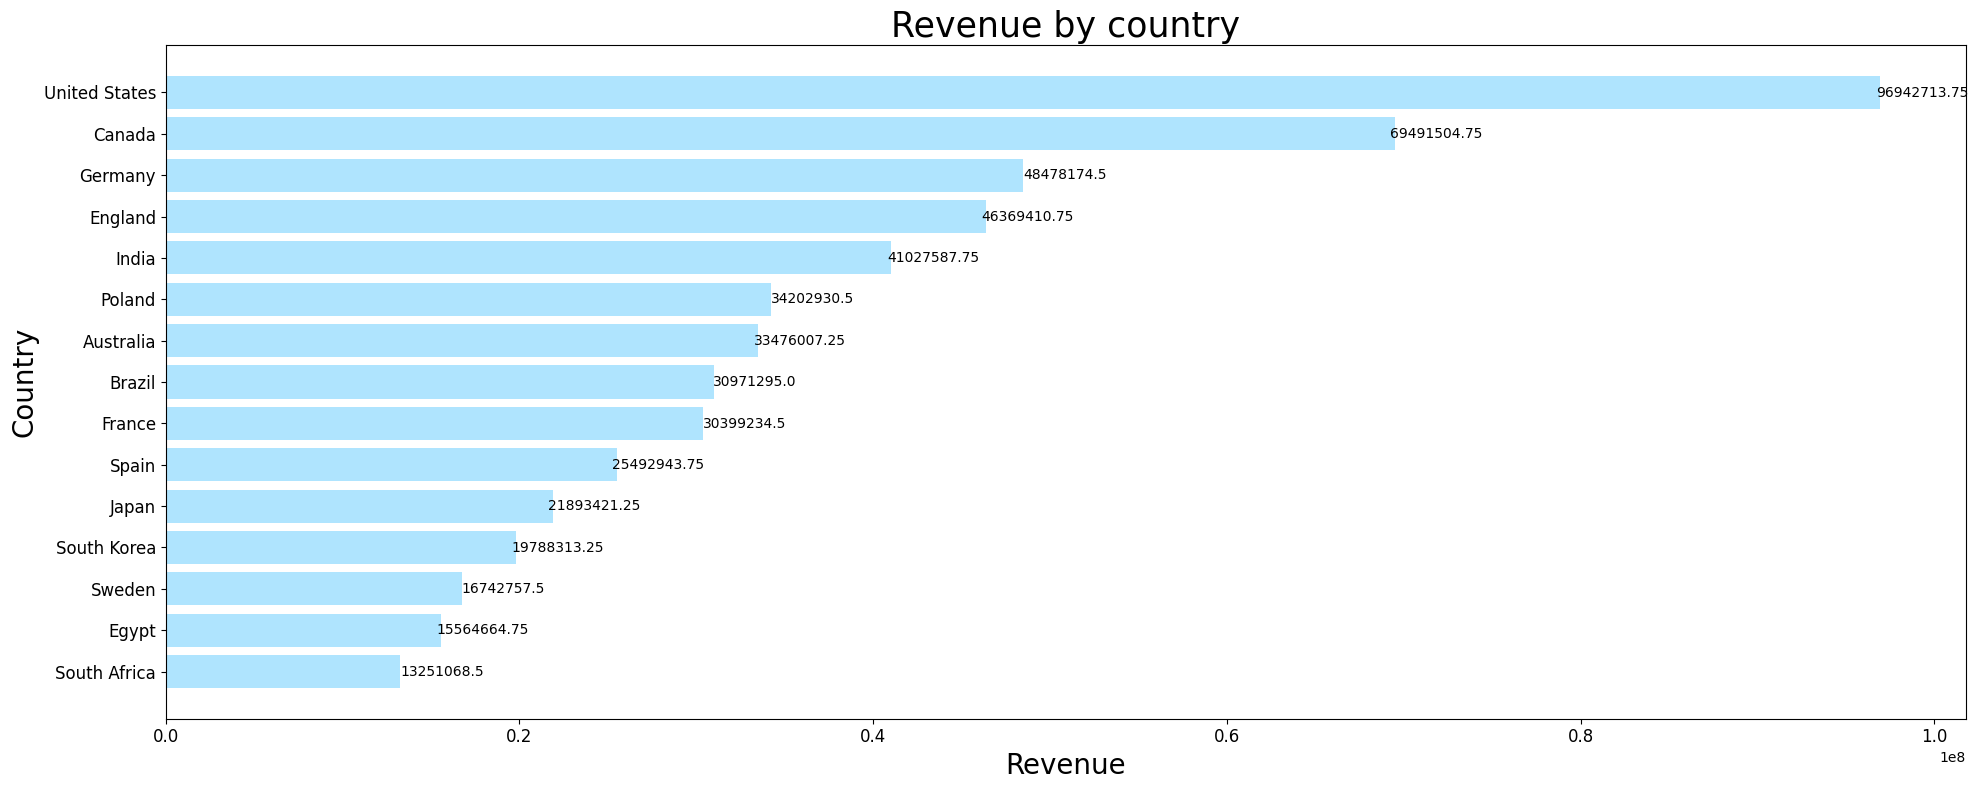

In [12]:
revenue_by_country.sort_values(by='REVENUE_GENERATED', ascending=True, inplace=True) # Sort values in ascending order of customer
country_index = revenue_by_country['COUNTRY'].tolist()
revenue_values = revenue_by_country['REVENUE_GENERATED'].tolist()

# Create a figure and subplot
fig, v2 = plt.subplots(figsize=(20,8))

# Create a horizontal bar chart 
v2.barh(country_index,revenue_values, align = 'center', color='#AFE4FE') # align define the alignment of x-ticks

# Display data labels
for x,y in zip(revenue_values ,country_index):

    label = x

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(30,-3), 
                 fontsize = 10,
                 ha='center') 

# State title of plot and the axes labels
v2.set_title('Revenue by country', fontsize = 25)
v2.set_ylabel('Country',fontsize = 20)
v2.set_xlabel('Revenue', fontsize = 20)

# Set font size of ticks on the x-axis and y-axis
v2.tick_params(labelsize = 12, axis ='both')

# Set tight layout for figure
fig.tight_layout()

# Display plot
plt.show()

### 2.3 Number of Orders by Country <a id="part2-3"></a>

In [13]:
orders_by_country = orders.group_by("COUNTRY").agg(F.count("COUNTRY").alias("COUNTRY_ORDERS")).to_pandas()
orders_by_country.head()

,COUNTRY,COUNTRY_ORDERS
0,Canada,1720133
1,Brazil,750661
2,Germany,1121312
3,Poland,836617
4,South Korea,489126


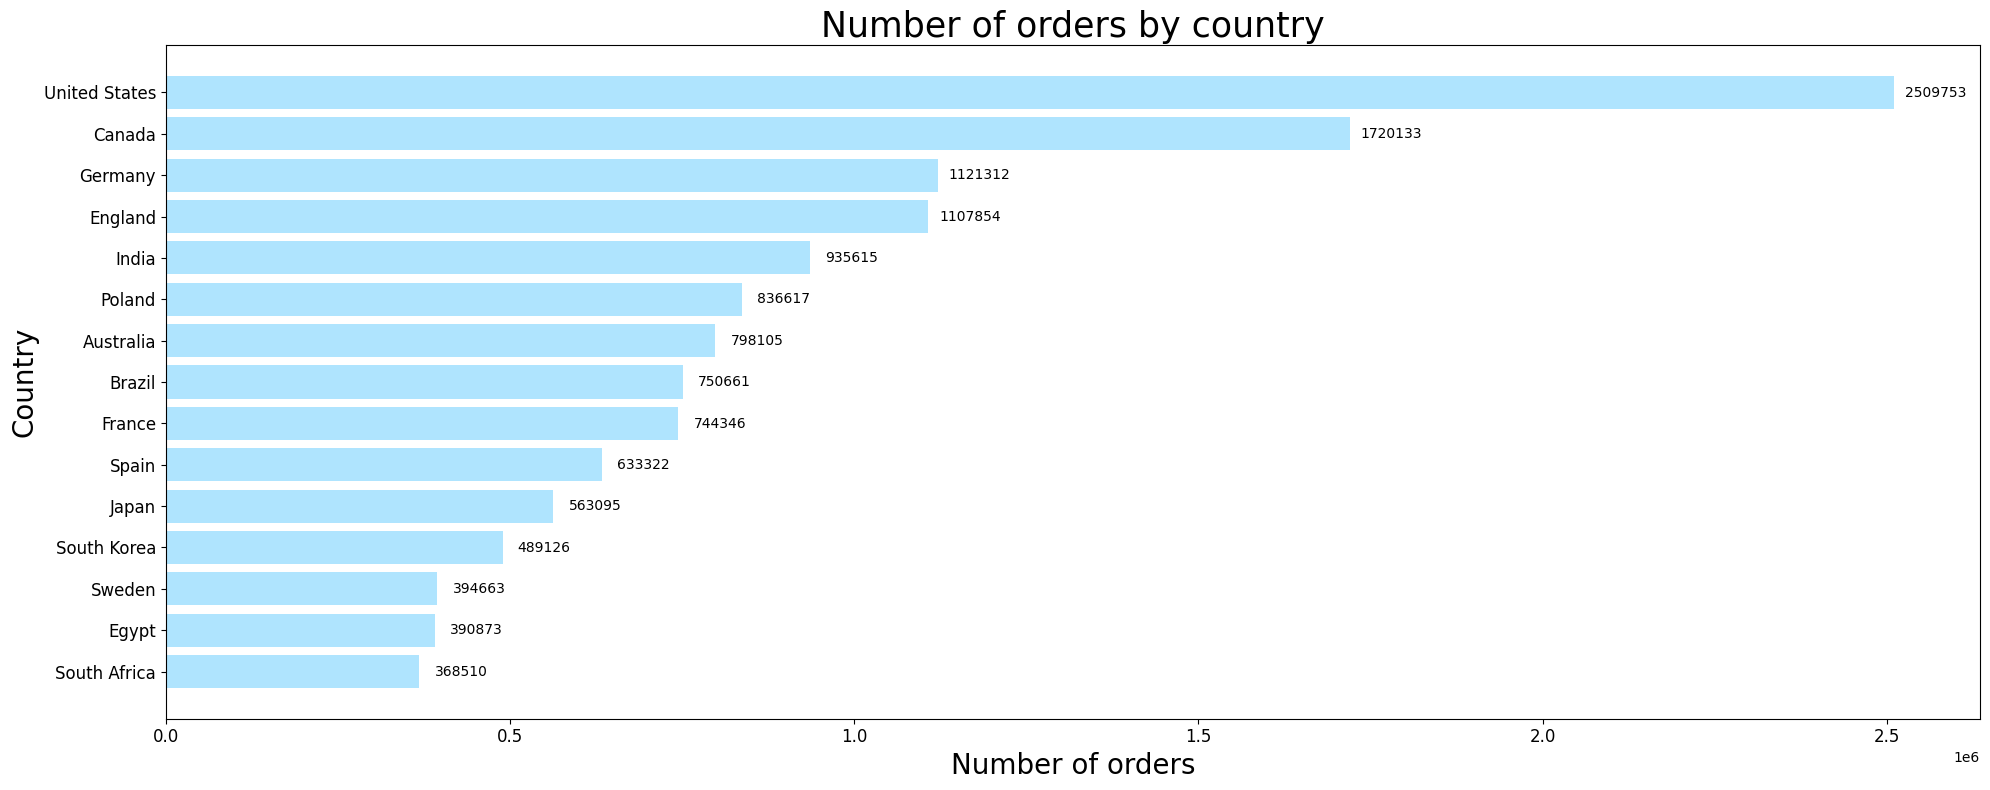

In [14]:
orders_by_country.sort_values(by='COUNTRY_ORDERS', ascending=True, inplace=True) # Sort values in ascending order of customer
country_index = orders_by_country['COUNTRY'].tolist()
order_values = orders_by_country['COUNTRY_ORDERS'].tolist()

# Create a figure and subplot
fig, v3 = plt.subplots(figsize=(20,8))

# Create a horizontal bar chart 
v3.barh(country_index,order_values, align = 'center', color='#AFE4FE') # align define the alignment of x-ticks

# Display data labels
for x,y in zip(order_values ,country_index):

    label = x

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(30,-3), 
                 fontsize = 10,
                 ha='center') 

# State title of plot and the axes labels
v3.set_title('Number of orders by country', fontsize = 25)
v3.set_ylabel('Country',fontsize = 20)
v3.set_xlabel('Number of orders', fontsize = 20)

# Set font size of ticks on the x-axis and y-axis
v3.tick_params(labelsize = 12, axis ='both')

# Set tight layout for figure
fig.tight_layout()

# Display plot
plt.show()

### 2.4 Cardinality Ratio <a id="part2-4"></a>
We want to see the number of unique values in each column to see whether there are any discrepancies.

In [15]:
# Finding the categorical columns in customer_df dataset
cat_cols = [c.name for c in customer_df.schema.fields if type(c.datatype) == T.StringType]
print(cat_cols)

['FIRST_NAME', 'LAST_NAME', 'CITY', 'COUNTRY', 'POSTAL_CODE', 'PREFERRED_LANGUAGE', 'GENDER', 'FAVOURITE_BRAND', 'MARITAL_STATUS', 'CHILDREN_COUNT', 'E_MAIL', 'PHONE_NUMBER']


In [16]:
# Cardinality ratio
for i in cat_cols:
    print(i + ":", customer_df.select(i).distinct().count())

FIRST_NAME: 2755
LAST_NAME: 1000
CITY: 30
COUNTRY: 15
POSTAL_CODE: 581
PREFERRED_LANGUAGE: 11
GENDER: 3
FAVOURITE_BRAND: 1
MARITAL_STATUS: 4
CHILDREN_COUNT: 7
E_MAIL: 197374
PHONE_NUMBER: 200001


### 2.5 Missing value <a id="part2-5"></a>

In [17]:
# Missing value percentage
for i in cat_cols:
    print(i + ":", (customer_df.count() - customer_df.na.drop(subset = i).count())/customer_df.count())

FIRST_NAME: 0.00022018513525658308
LAST_NAME: 0.0
CITY: 0.0
COUNTRY: 0.0
POSTAL_CODE: 0.04790599442796801
PREFERRED_LANGUAGE: 0.0
GENDER: 0.0
FAVOURITE_BRAND: 1.0
MARITAL_STATUS: 0.0
CHILDREN_COUNT: 0.0
E_MAIL: 0.0
PHONE_NUMBER: 0.0


From the above code, the following columns have null values:
- FIRST_NAME
- POSTAL_CODE
- FAVOURITE_BRAND. 

This would help us when we are doing null value imputation in the upcoming steps. 

## 3. Data Preparation <a id="part3"></a>

### 3.1 Create dataframe <a id="part3-1"></a>
As mentioned earlier, our group will be focusing on the customers based in the US. Hence, we will need to filter the customer data to US. We are also doing basic data preparation to prepare our datasets so far for subsequent steps. 

In [18]:
# Filtering of customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")
us_customer_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |Donald        |Faulkner     |San Mateo  |United States  |94010          |English               |Male         |NULL               |Single              |0                 |201

In [19]:
# After filtering of customer dataset to only US, we will be filtering and looking at the orders 
# based on these customers only

customer_US = us_customer_df.select(F.col("CUSTOMER_ID"))
order_header_df = order_header_df.join(customer_US, order_header_df.CUSTOMER_ID == customer_US.CUSTOMER_ID, lsuffix = "", rsuffix = "_US")
order_header_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789.0         |194230         |NULL           |200540458   |08:00:00 

### 3.2 Null Value Treatment for us_customer_df <a id="part3-2"></a>
After creating of the relevant data frames that we need, we will need to do null value treatment to further prepare our dataset for modelling. However, based on the data exploration done previously, we realised that the columns that contains null value will not be affecting the clustering of the model. Hence, we will drop the columns. 

In [20]:
# Drop irrelevant columns that will not be affecting the clustering of model and/or are all null
us_customer_df = us_customer_df.drop(["FIRST_NAME", "LAST_NAME", "FAVOURITE_BRAND", "E_MAIL", "PHONE_NUMBER", "POSTAL_CODE"])

# Update categorical columns list
cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]
print(cat_cols)

['CITY', 'COUNTRY', 'PREFERRED_LANGUAGE', 'GENDER', 'MARITAL_STATUS', 'CHILDREN_COUNT']


In [21]:
# Missing value percentage
for i in cat_cols:
    print(i + ":", (us_customer_df.count() - us_customer_df.na.drop(subset = i).count())/us_customer_df.count())

CITY: 0.0
COUNTRY: 0.0
PREFERRED_LANGUAGE: 0.0
GENDER: 0.0
MARITAL_STATUS: 0.0
CHILDREN_COUNT: 0.0


### 3.3 Replacing values <a id="part3-3"></a>

In [22]:
# Update categorical columns list
cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]

# Distinct values in each column
dist_vals = us_customer_df.select([F.array_agg(col, is_distinct=True).as_(col) for col in cat_cols]).collect()[0].as_dict()
dist_vals

{'CITY': '[\n  "San Mateo",\n  "New York City",\n  "Boston",\n  "Denver",\n  "Seattle"\n]',
 'COUNTRY': '[\n  "United States"\n]',
 'PREFERRED_LANGUAGE': '[\n  "English"\n]',
 'GENDER': '[\n  "Male",\n  "Undisclosed",\n  "Female"\n]',
 'MARITAL_STATUS': '[\n  "Single",\n  "Married",\n  "Undisclosed",\n  "Divorced/Seperated"\n]',
 'CHILDREN_COUNT': '[\n  "0",\n  "1",\n  "Undisclosed",\n  "2",\n  "4",\n  "5+",\n  "3"\n]'}

Based on the above code, we can drop "COUNTRY" and "PREFERRED_LANGAUGE" as they contain the same value. 

In [23]:
# Drop "COUNTRY" and "PREFERRED_LANGAUGE"
us_customer_df = us_customer_df.drop(["COUNTRY", "PREFERRED_LANGUAGE"])

#### Replace 'Undisclosed' in CHILDREN_COUNT
Since most of the other values in CHILDREN_COUNT is an integer, let's replace the values 'Undisclosed' and '5+'. This would help in the encoding portion.

In [24]:
us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.iff(F.col("CHILDREN_COUNT") == "Undisclosed", "0", F.col("CHILDREN_COUNT")))

We are replacing the "Undisclosed" values in the children count column with '0' because we don't have information about the number of children for those customers. Since the children count column represents the count of children a customer has, it doesn't make sense to keep the "Undisclosed" as a value. We are assuming that customers with "Undisclosed" values in the children count column have no children. We are not replacing or dropping them because it wouldn't make sense to encode those values, and dropping the rows would result in significant data loss.

In [25]:
us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.iff(F.col("CHILDREN_COUNT")== "5+", "5", F.col("CHILDREN_COUNT")))

By replacing the "5+" values with '5', we are making a reasonable assumption to simplify the data and create a more consistent representation of the children count. This simplification allows for easier analysis and modeling while still capturing the general information about customers with a larger number of children.

Now that all the values in "CHILDREN_COUNT" is an integer, we will convert the column to integer.

In [26]:
# Convert "CHILDREN_COUNT" to integer
us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.col("CHILDREN_COUNT").cast("int"))

### 3.4 Categorical encoding for us_customer_df <a id="part3-4"></a>
Categorical encoding is needed as machine learning models are not able to handle categorical variables. 

In [27]:
# Update categorical columns list
cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]

# Distinct values in each column
dist_vals = us_customer_df.select([F.array_agg(col, is_distinct=True).as_(col) for col in cat_cols]).collect()[0].as_dict()
dist_vals

{'CITY': '[\n  "San Mateo",\n  "New York City",\n  "Boston",\n  "Denver",\n  "Seattle"\n]',
 'GENDER': '[\n  "Male",\n  "Undisclosed",\n  "Female"\n]',
 'MARITAL_STATUS': '[\n  "Single",\n  "Married",\n  "Undisclosed",\n  "Divorced/Seperated"\n]'}

We will use categorical encoding to ensure that all the data are in numerical format. “CITY”, “GENDER” and “MARITAL_STATUS” in the customer dataset will be encoded.

In [28]:
# city [Frequency Encoding]
us_customer_df.group_by("CITY").agg(F.count("CUSTOMER_ID").alias("CID"))
freq_enc = us_customer_df.groupBy("CITY").agg(F.count("CUSTOMER_ID").alias("city_frequency"))
    # join the encoded column back to the original DataFrame
us_customer_df = us_customer_df.join(freq_enc, us_customer_df.CITY == freq_enc.CITY, lsuffix = "", rsuffix = "_FREQ_ENC")

Using frequency encoding for "CITY" can help to retain valuable information such as the distribution of each city in the dataset.

Label encoding will be applied to “GENDER” and “MARITAL_STATUS”. 

In [29]:
# Gender [Label Encoding]
#  Male -> 0
#  Female -> 1
#  Undisclosed -> 2

us_customer_df = us_customer_df.withColumn("Gender", F.when(us_customer_df["GENDER"] == "Male", "0")
                                             .when(us_customer_df["GENDER"] == "Female", "1").otherwise("2"))

In [30]:
# Marital status [Label Encoding]
#  Married -> 0 
#  Single -> 1
#  Divorced/seperated -> 2 
#  Undisclosed -> 3

us_customer_df = us_customer_df.withColumn(
    "MARITAL_STATUS",
    F.when(us_customer_df["MARITAL_STATUS"] == "Married", "0")
    .when(us_customer_df["MARITAL_STATUS"] == "Single", "1")
    .when(us_customer_df["MARITAL_STATUS"] == "Divorced/Seperated", "2")
    .otherwise("3")
)

### 3.5 Calculating customer's age <a id="part3-5"></a>
“BIRTHDAY_DATE” will be replaced by “AGE” instead, with the last order transaction date recorded based on all the customers as the current date. 

In [31]:
# Calculating of the age of each customer based on the last order transaction date recorded based on all customers as current date 
last_date = order_header_df.agg(F.max("ORDER_TS")).collect()[0][0]
us_customer_df = us_customer_df.withColumn("Last_date", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), last_date, last_date))
us_customer_df = us_customer_df.withColumn("AGE", F.datediff("year", F.col("BIRTHDAY_DATE"), F.col("Last_date")))

In [32]:
last_date

datetime.datetime(2022, 11, 1, 22, 58, 56)

In [33]:
# Dropping of categorical columns and unnecessary columns 
us_customer_df = us_customer_df.drop("CITY", "CITY_FREQ_ENC", "LAST_DATE", "BIRTHDAY_DATE")

# Final customer dataframe
us_customer_df.show(10)

--------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"SIGN_UP_DATE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |
--------------------------------------------------------------------------------------------------------------
|118            |2019-07-07      |0                 |10613             |0         |1                 |34     |
|189            |2020-03-06      |1                 |10613             |2         |0                 |38     |
|204            |2021-10-10      |0                 |10613             |0         |3                 |43     |
|42             |2020-07-11      |0                 |10613             |2         |1                 |56     |
|59             |2020-12-29      |2                 |10613             |0         |0                 |61     |
|65             |2020-11-05      |5                 |10613             |0         |2                 |64     |
|

## 4. Calculating RFM (Recency, Frequency & Monetary Value) <a id="part4"></a>
To prepare our dataset for clustering later on, we will be calculating the RFM. 

In [34]:
# Dropping rows that had null in customer id as we are only focusing on members 
order_header_df = order_header_df.na.drop(subset="CUSTOMER_ID")

### 4.1 Calculation of Recency <a id="part4-1"></a>
To calculate the recency of orders for each customer, we will take the last order timestamp of the customer minus the current date identified. 

In [35]:
# Finding the last order time stamp for each customer
customer_last_order_timestamp = order_header_df.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))

In [36]:
# Finding the first and latest transaction timestamps

# First transaction timestamp
order_header_df.agg(F.min("ORDER_TS")).show()

# Lastest transaction timestamp
order_header_df.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [37]:
# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Inserting new column: current date which the lastest transaction timestamp
customer_recency = customer_last_order_timestamp.with_column("CURRENT DATE", F.iff(F.col("LAST_ORDER_TS") == F.col("LAST_ORDER_TS"), "2022-11-01", "0"))

# Calculate recency days
customer_recency = customer_recency.with_column("RECENCY_DAYS", F.datediff('day', customer_recency["LAST_ORDER_TS"], customer_recency["CURRENT DATE"]))
customer_recency.show()

-------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"CURRENT DATE"  |"RECENCY_DAYS"  |
-------------------------------------------------------------------------
|72163          |2022-10-24 11:41:22  |2022-11-01      |8               |
|141003         |2022-10-29 21:56:20  |2022-11-01      |3               |
|157807         |2022-10-26 21:05:14  |2022-11-01      |6               |
|110135         |2022-10-29 10:48:57  |2022-11-01      |3               |
|69163          |2022-10-15 12:56:11  |2022-11-01      |17              |
|99059          |2022-10-28 19:19:56  |2022-11-01      |4               |
|198935         |2022-10-29 09:39:15  |2022-11-01      |3               |
|181495         |2022-10-17 08:49:14  |2022-11-01      |15              |
|79999          |2022-10-31 09:24:34  |2022-11-01      |1               |
|66588          |2022-10-15 20:10:31  |2022-11-01      |17              |
--------------------------------------

In [38]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency = customer_recency.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
customer_final = temp_customer_recency.join(customer_df, 
                                customer_df.CUSTOMER_ID==temp_customer_recency.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

### 4.2 Calculation of Frequency <a id="part4-2"></a>
To calculate the frequency of orders for each customer, we will be calculating the total order by customers divided by the duration between their first order and the current date identified.

In [39]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp = order_header_df.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|123263         |2020-01-26 22:16:29  |
|181819         |2019-10-01 19:26:58  |
|97743          |2019-10-12 16:04:37  |
|101963         |2020-01-08 21:52:36  |
|63905          |2019-10-05 21:43:12  |
---------------------------------------



In [40]:
# Calculating the total number of orders for each customer
total_order_by_cust = order_header_df.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|169614         |74             |
|107415         |64             |
|105551         |57             |
|111566         |51             |
|96477          |68             |
---------------------------------



In [41]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq = customer_df.join(customer_first_order_timestamp, customer_df.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq = customer_freq.join(total_order_by_cust, customer_freq.CUSTOMER_ID==total_order_by_cust.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq = customer_freq.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-11-01", "0"))
customer_freq = customer_freq.with_column("YEARS_WITH_US",F.datediff("day", customer_freq["FIRST_ORDER_TS"], customer_freq["CURRENT DATE"])/365)
customer_freq = customer_freq.with_column("CUSTOMER_FREQUENCY", customer_freq["TOTAL_ORDER"]/customer_freq["YEARS_WITH_US"])

In [42]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq = customer_freq.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
customer_final = temp_customer_freq.join(customer_final, 
                                customer_final.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")

### 4.3 Calculation of Monetary Value <a id="part4-3"></a>
To calculate the monetary value for each customer, we will be calculating the total sales generated by each customer divided by the number of years the customer has ordered with Tasty Bytes. 

In [43]:
 # Calculate the total sales generated by each customer 
total_amount_spent = order_header_df.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary = total_amount_spent.join(customer_first_order_timestamp, total_amount_spent.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary = customer_monetary.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-08-01", "0"))
customer_monetary = customer_monetary.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary["FIRST_ORDER_TS"], customer_monetary["CURRENT DATE"])/365)
customer_monetary = customer_monetary.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [44]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_freq = customer_monetary.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
customer_final = temp_customer_freq.join(customer_final, customer_final.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")

### 4.4 Dataframe with RFM Calculation <a id="part4-4"></a>

In [45]:
customer_final = customer_final.select(
    ["CUSTOMER_ID", "TOTAL_SPENT", 
     "YEARS_WITH_US", "TOTAL_ORDER", 
     "RECENCY_DAYS", "CUSTOMER_FREQUENCY", "MONETARY_VALUE"])
customer_final.show()

------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |
------------------------------------------------------------------------------------------------------------------------------
|160078         |2411.0000      |2.416438         |58             |0               |21.735114             |997.7495801672    |
|50677          |2343.7500      |2.504110         |56             |3               |20.318094             |935.9612796562    |
|78808          |2012.0000      |2.575342         |49             |16              |17.330428             |781.2554604398    |
|86849          |2255.5000      |2.506849         |57             |27              |20.660378             |899.7350857591    |
|142283         |2248.5000      |2.572603         |61             |21              |21.595535             |874.

### 4.5 Outliers Treatment <a id = "part4-5"></a>
In this section, we will be looking at the numerical columns' distributions of the above dataframe. Outliers will be treated if deemed neccessary. 

In [46]:
# identifying numerical columns
num_col = [c.name for c in customer_final.schema.fields if type(c.datatype) != T.StringType ]
num_col

['CUSTOMER_ID',
 'TOTAL_SPENT',
 'YEARS_WITH_US',
 'TOTAL_ORDER',
 'RECENCY_DAYS',
 'CUSTOMER_FREQUENCY',
 'MONETARY_VALUE']

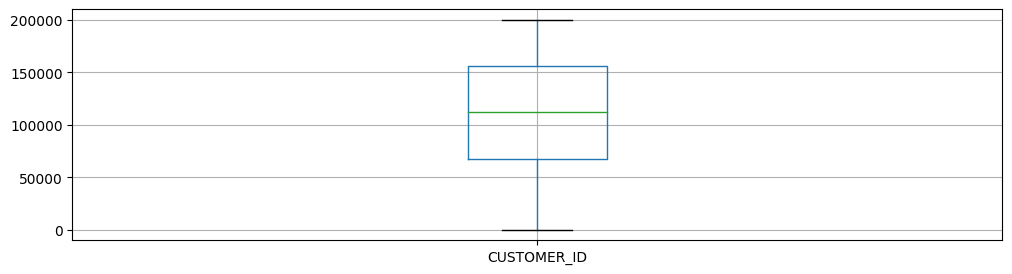

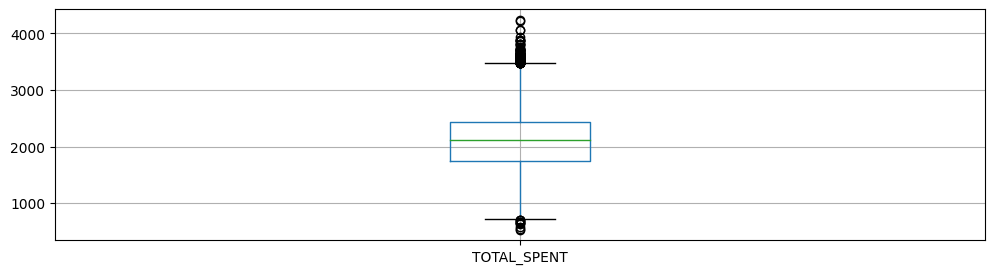

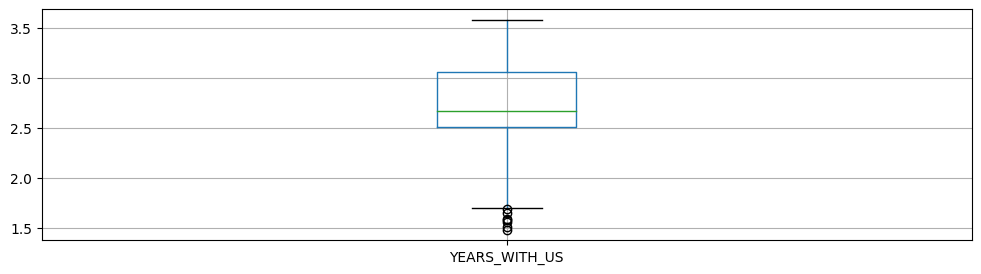

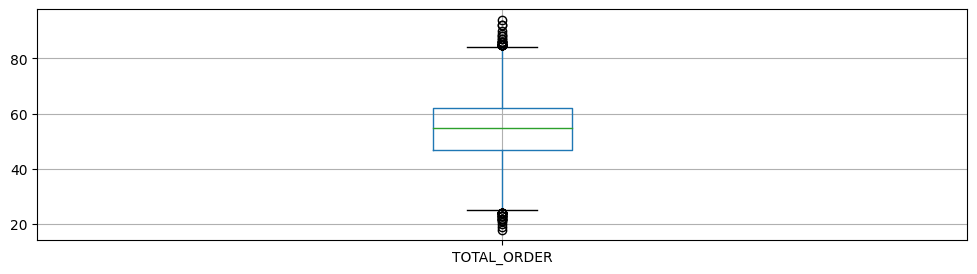

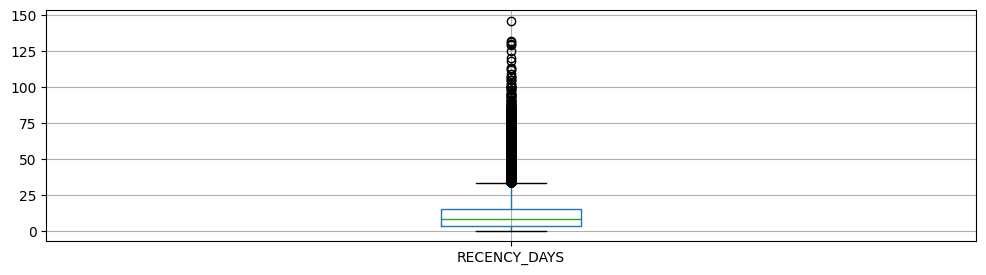

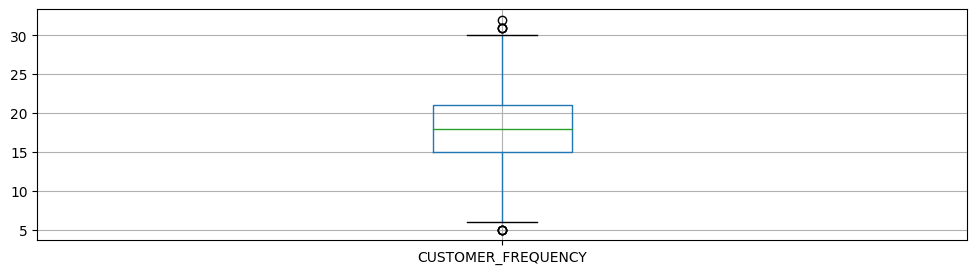

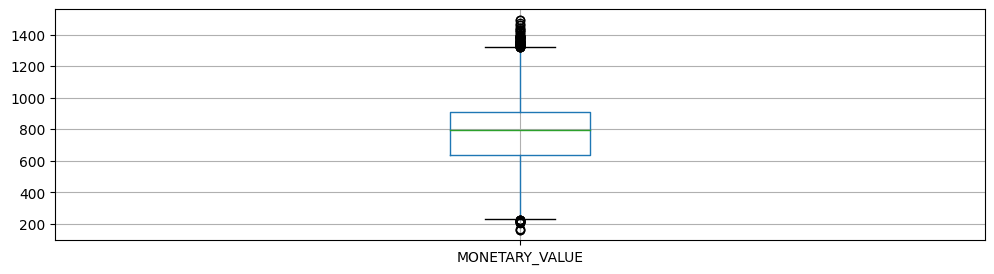

In [47]:
# we need a pandas dataframe to work with
cfpd = customer_final.to_pandas()

# casting columns to integer to help with subsequent steps
cfpd["CUSTOMER_FREQUENCY"] = cfpd["CUSTOMER_FREQUENCY"].astype("int")
cfpd["MONETARY_VALUE"] = cfpd["MONETARY_VALUE"].astype("int")

# box plot for each numerical column
for column in num_col:
    plt.figure(figsize=(12, 3))
    cfpd.boxplot(column = [column])

After evaluating the box plot diagrams for all the numerical columns, we have decided to not do any outlier treatments. 

In [48]:
# Merge with customer details
customer_final = customer_final.join(us_customer_df, customer_final.CUSTOMER_ID == us_customer_df.CUSTOMER_ID, lsuffix = "", rsuffix = "_enc")

# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_final = customer_final.drop(["CUSTOMER_ID_ENC", "SIGN_UP_DATE"])
customer_final.show(10)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|32816          |1897.2500      |2.558904         |60             |6               |21.345029             |741.4307062711    |0                 |10016             |0         |0                 |65     |
|21460          |2178.0000      |2.572603         |51             |6               |18.055283             |846.6133328772    |0                 |10016             |0         |1            

In [49]:
# Converting of dataframe to pandas for clustering of model 
customer_final = customer_final.to_pandas()

# Check Dtype of each columns
customer_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46300 entries, 0 to 46299
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CUSTOMER_ID         46300 non-null  int32  
 1   TOTAL_SPENT         46300 non-null  float64
 2   YEARS_WITH_US       46300 non-null  float64
 3   TOTAL_ORDER         46300 non-null  int64  
 4   RECENCY_DAYS        46300 non-null  int32  
 5   CUSTOMER_FREQUENCY  46300 non-null  object 
 6   MONETARY_VALUE      46300 non-null  object 
 7   CHILDREN_COUNT      46300 non-null  int8   
 8   CITY_FREQUENCY      46300 non-null  int64  
 9   GENDER              46300 non-null  object 
 10  MARITAL_STATUS      46300 non-null  object 
 11  AGE                 46300 non-null  int32  
dtypes: float64(2), int32(3), int64(2), int8(1), object(4)
memory usage: 3.4+ MB


In [50]:
# Converting all columns to numeric datatype
customer_final["CUSTOMER_FREQUENCY"] = customer_final["CUSTOMER_FREQUENCY"].astype("float")
customer_final["MONETARY_VALUE"] = customer_final["MONETARY_VALUE"].astype("float")
customer_final["GENDER"] = customer_final["GENDER"].astype("float")
customer_final["MARITAL_STATUS"] = customer_final["MARITAL_STATUS"].astype("float")

In [51]:
# Information of the final customer dataset to be used for clustering
customer_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46300 entries, 0 to 46299
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CUSTOMER_ID         46300 non-null  int32  
 1   TOTAL_SPENT         46300 non-null  float64
 2   YEARS_WITH_US       46300 non-null  float64
 3   TOTAL_ORDER         46300 non-null  int64  
 4   RECENCY_DAYS        46300 non-null  int32  
 5   CUSTOMER_FREQUENCY  46300 non-null  float64
 6   MONETARY_VALUE      46300 non-null  float64
 7   CHILDREN_COUNT      46300 non-null  int8   
 8   CITY_FREQUENCY      46300 non-null  int64  
 9   GENDER              46300 non-null  float64
 10  MARITAL_STATUS      46300 non-null  float64
 11  AGE                 46300 non-null  int32  
dtypes: float64(6), int32(3), int64(2), int8(1)
memory usage: 3.4 MB


In [52]:
customer_final['TOTAL_SPENT'] = customer_final["TOTAL_SPENT"].astype(float)
customer_final['YEARS_WITH_US'] = customer_final["YEARS_WITH_US"].astype(float)
customer_final['TOTAL_ORDER'] = customer_final["TOTAL_ORDER"].astype(float)
customer_final['RECENCY_DAYS'] = customer_final["RECENCY_DAYS"].astype(float)

In [53]:
# Overview of the final customer dataset to be used for clustering
customer_final.head(5)

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,TOTAL_ORDER,RECENCY_DAYS,CUSTOMER_FREQUENCY,MONETARY_VALUE,CHILDREN_COUNT,CITY_FREQUENCY,GENDER,MARITAL_STATUS,AGE
0,144543,1921.75,2.402740,52.0,80.0,19.587200,799.816043,5,10016,0.0,2.0,72
1,104746,2165.00,2.506849,51.0,2.0,18.485602,863.633988,0,10016,1.0,1.0,59
2,121830,2085.00,2.520548,59.0,4.0,21.279642,827.201069,0,10016,0.0,1.0,23
3,38499,2148.50,2.580822,57.0,0.0,20.120888,832.486704,0,10016,1.0,1.0,31
4,66856,2641.00,2.345205,63.0,35.0,24.256332,1126.127567,3,10016,1.0,0.0,34


## 5. Clustering Model <a id="part5"></a>

## 5.1 Baseline Model <a id="part5-1"></a>
We will use this current dataset to build a clustering model and set this as our baseline model for us to compare to when we make more improvements to the model. By having a baseline clustering model, we will be able to compare how well the other clustering models are doing compared to it and whether the new models are better in terms of clustering accuracy. 

In [54]:
# Scaling of dataframe to make sure that all variables are standardise in a fixed range 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_final)

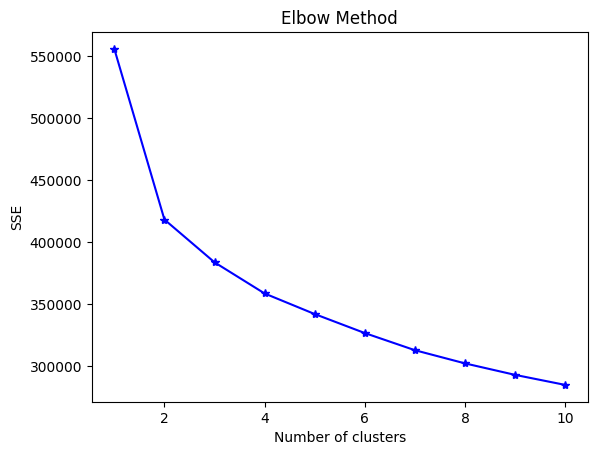

In [55]:
# Finding the optimal number of clusters based on the elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [56]:
# Building of the K-means model based on the optimal n_cluster identified from the elbow method
kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
# Fit the model and assign each data point to the cluster
y_pred = kmeans.fit_predict(X_scaled) # fit and then predict

In [57]:
customer_final['cluster'] = y_pred
customer_final.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,TOTAL_ORDER,RECENCY_DAYS,CUSTOMER_FREQUENCY,MONETARY_VALUE,CHILDREN_COUNT,CITY_FREQUENCY,GENDER,MARITAL_STATUS,AGE,cluster
0,144543,1921.75,2.402740,52.0,80.0,19.587200,799.816043,5,10016,0.0,2.0,72,1
1,104746,2165.00,2.506849,51.0,2.0,18.485602,863.633988,0,10016,1.0,1.0,59,1
2,121830,2085.00,2.520548,59.0,4.0,21.279642,827.201069,0,10016,0.0,1.0,23,1
3,38499,2148.50,2.580822,57.0,0.0,20.120888,832.486704,0,10016,1.0,1.0,31,1
4,66856,2641.00,2.345205,63.0,35.0,24.256332,1126.127567,3,10016,1.0,0.0,34,1


In [58]:
segment_characteristics = customer_final.groupby('cluster').mean()
print(segment_characteristics)

           CUSTOMER_ID  TOTAL_SPENT  YEARS_WITH_US  TOTAL_ORDER  RECENCY_DAYS  \
cluster                                                                         
0        100446.439524  1507.502019       3.019789    40.606124     15.787833   
1        114247.691811  2310.833388       2.674193    59.240952      9.792164   

         CUSTOMER_FREQUENCY  MONETARY_VALUE  CHILDREN_COUNT  CITY_FREQUENCY  \
cluster                                                                       
0                 12.550777      505.886308        1.107123    10393.490767   
1                 20.331218      867.581136        1.089077     9027.131426   

           GENDER  MARITAL_STATUS        AGE  
cluster                                       
0        0.672876        0.900711  49.448477  
1        0.674055        0.902666  49.441863  


In [59]:
# Evaluate the clustering model based on the silhouette score 

from sklearn.model_selection import KFold, cross_val_score, train_test_split
#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(customer_final.drop("cluster", axis = 1), customer_final['cluster'], test_size=0.3, random_state=42)

In [60]:
clusterer = KMeans(n_clusters=2, random_state=42)
clusterer.fit_predict(X_train)

score = silhouette_score(X_train, clusterer.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.615


## 5.2 Improvements to the model <a id="part5-2"></a>

We tried several ways of feature engineering and selection of columns to make improvements to the model and here's the results:
- Baseline Silhoutte Score = 0.615
- Baseline without "useless" columns = 0.630
- Model with feature engineering = 0.615
- Model with feature enginnering and without "useless" columns = 0.600
- Model with individual cluster = 0.615
- Model with individual cluster without "useless" columns = 0.629
- Model with individual cluster and with feature engineering = 0.614
- Model with individual cluster and with feature engineering and without "useless" columns = 0.600

Therefore, the model with the highest silhoutte score is the one where we remove less significant columns. 

In [61]:
# Determine the less significant features when it comes to clustering 
segment_characteristics = customer_final.groupby('cluster').mean()
print(segment_characteristics)

           CUSTOMER_ID  TOTAL_SPENT  YEARS_WITH_US  TOTAL_ORDER  RECENCY_DAYS  \
cluster                                                                         
0        100446.439524  1507.502019       3.019789    40.606124     15.787833   
1        114247.691811  2310.833388       2.674193    59.240952      9.792164   

         CUSTOMER_FREQUENCY  MONETARY_VALUE  CHILDREN_COUNT  CITY_FREQUENCY  \
cluster                                                                       
0                 12.550777      505.886308        1.107123    10393.490767   
1                 20.331218      867.581136        1.089077     9027.131426   

           GENDER  MARITAL_STATUS        AGE  
cluster                                       
0        0.672876        0.900711  49.448477  
1        0.674055        0.902666  49.441863  


By comparing the mean of each cluster in each column, we can tell if the feature is making a difference when it comes to clustering. For columns like:
- CUSTOMER_ID
- CHILDREN_COUNT
- MARITAL_STATUS
- AGE
- GENDER
where the mean between the cluster is not significant, we are dropping it. 

In [62]:
# Drop the less significant columns
customer_final = customer_final.drop(columns=["CUSTOMER_ID", "CHILDREN_COUNT", "MARITAL_STATUS", "AGE", "GENDER"])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(customer_final.drop("cluster", axis = 1), customer_final['cluster'], test_size=0.3, random_state=42)

clusterer = KMeans(n_clusters=2, random_state=42)
clusterer.fit_predict(X_train)
score = silhouette_score(X_train, clusterer.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.631


By clustering Tasty Byte’s customers into 2 main groups, we can gain valuable insights into their customer base that one of the groups is high value customers, while the other group is low value customers. With this information, Tasty Bytes will then be able to know from a business perspective which are the customers that they would like to target. By knowing who the higher value customers are, Tasty Bytes will know that they would have to do something to retain these customers as they are consistently and more likely to contribute significantly to Tasty Bytes’ revenue and profitability. Knowing about the low value customers will also help Tasty Bytes to know that they should work on retaining these customers by marketing means to improve the customer loyalty and the revenue and profitability of Tasty Bytes. 

## 6. Prediction of Monetary Value <a id="part6"></a>

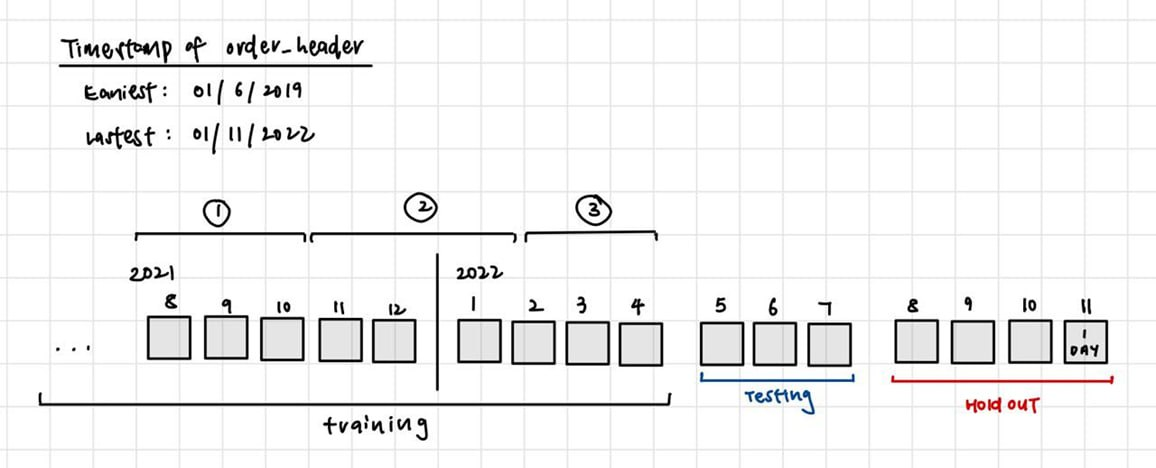

## 6.1 Data Preparation <a id="part6-1"></a>

### 6.1.1 Create Dataframe <a id="part6-1-1"></a>

In [63]:
# Load in original dataset from snowflake
order_header_df = session.table("FROSTBYTE_TASTY_BYTES.raw_pos.order_header")
customer_df = session.table("FROSTBYTE_TASTY_BYTES.raw_customer.customer_loyalty")

# Find the lastest transaction date in the order header table 
lastest_transaction = order_header_df.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
lastest_transaction

datetime.datetime(2022, 11, 1, 22, 59, 59)

In [64]:
# Create training dataframe (2019 June to 2022 Apr; exclude last 6 months of data)
order_till_2022apr = order_header_df.withColumn("LAST_DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction, lastest_transaction))
order_till_2022apr = order_till_2022apr.filter(F.datediff("month", F.col("ORDER_TS"), F.col("LAST_DATE")) > 6)

# Check if the timeframe in the dataset is correct
# Show min & max order timestamp after filtering
order_till_2022apr.agg(F.min("ORDER_TS")).show()
order_till_2022apr.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 08:00:07  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-04-30 23:00:00  |
-----------------------



In [65]:
# Filtering of customer dataset to only US
us_customer = customer_df.filter(F.col("COUNTRY")=="United States")
# Filer US Customers
order_till_2022apr = order_till_2022apr.join(us_customer, order_till_2022apr.CUSTOMER_ID == us_customer.CUSTOMER_ID,lsuffix = "", rsuffix = "_US")

In [66]:
order_till_2022apr.count()

1856943

In [67]:
# Filtering of customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")

# Encoding for customer's city
# city [Frequency Encoding]
us_customer_df.group_by("CITY").agg(F.count("CUSTOMER_ID").alias("CID"))
freq_enc = us_customer_df.groupBy("CITY").agg(F.count("CUSTOMER_ID").alias("city_frequency"))
    # join the encoded column back to the original DataFrame
us_customer_df = us_customer_df.join(freq_enc, us_customer_df.CITY == freq_enc.CITY, lsuffix = "", rsuffix = "_FREQ_ENC")

# only customer's city is needed
us_customer_df = us_customer_df.select("CUSTOMER_ID", "CITY_FREQUENCY")

### 6.1.2 Calculating RFM <a id="part6-1-2"></a>
#### Recency

In [68]:
# Finding the last order time stamp for each customer
customer_last_order_timestamp = order_till_2022apr.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))

In [69]:
# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Inserting new column: current date which the lastest transaction timestamp
customer_recency = customer_last_order_timestamp.with_column("CURRENT DATE", F.iff(F.col("LAST_ORDER_TS") == F.col("LAST_ORDER_TS"), "2022-05-01", "0"))

# Calculate recency days
customer_recency = customer_recency.with_column("RECENCY_DAYS", F.datediff('day', customer_recency["LAST_ORDER_TS"], customer_recency["CURRENT DATE"]))
customer_recency.show()

-------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"CURRENT DATE"  |"RECENCY_DAYS"  |
-------------------------------------------------------------------------
|174512         |2022-04-15 19:24:39  |2022-05-01      |16              |
|62386          |2022-04-15 14:44:27  |2022-05-01      |16              |
|27738          |2022-04-25 18:53:33  |2022-05-01      |6               |
|72832          |2022-04-14 11:16:04  |2022-05-01      |17              |
|54608          |2022-03-25 14:53:54  |2022-05-01      |37              |
|175515         |2022-04-24 12:24:43  |2022-05-01      |7               |
|137150         |2022-04-02 18:41:02  |2022-05-01      |29              |
|67568          |2022-04-30 15:32:32  |2022-05-01      |1               |
|120975         |2022-04-26 18:40:33  |2022-05-01      |5               |
|66598          |2022-03-25 11:20:57  |2022-05-01      |37              |
--------------------------------------

In [70]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency = customer_recency.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
us_customer_df = temp_customer_recency.join(us_customer_df, 
                                us_customer_df.CUSTOMER_ID==temp_customer_recency.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

# Drop uneccessary columns created when joining 
us_customer_df = us_customer_df.drop("CUSTOMER_ID_RECENCY")

#### Frequency

In [71]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp = order_header_df.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|NULL           |2019-01-01 08:00:07  |
|216851         |2019-10-19 17:58:07  |
|204640         |2019-11-30 10:22:44  |
|9475           |2019-10-14 19:21:56  |
|6712           |2019-11-22 12:42:28  |
---------------------------------------



In [72]:
# Calculating the total number of orders for each customer
total_order_by_cust = order_header_df.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|NULL           |234837284      |
|190702         |63             |
|97913          |72             |
|93938          |53             |
|85897          |60             |
---------------------------------



In [73]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq = customer_df.join(customer_first_order_timestamp, customer_df.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq = customer_freq.join(total_order_by_cust, customer_freq.CUSTOMER_ID==total_order_by_cust.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq = customer_freq.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-05-01", "0"))
customer_freq = customer_freq.with_column("YEARS_WITH_US",F.datediff("day", customer_freq["FIRST_ORDER_TS"], customer_freq["CURRENT DATE"])/365)
customer_freq = customer_freq.with_column("CUSTOMER_FREQUENCY", customer_freq["TOTAL_ORDER"]/customer_freq["YEARS_WITH_US"])

In [74]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq = customer_freq.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
us_customer_df = temp_customer_freq.join(us_customer_df, 
                                us_customer_df.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")
# Drop uneccessary columns created when joining 
us_customer_df = us_customer_df.drop("CUSTOMER_ID_FREQUENCY")

#### Monetary

In [75]:
 # Calculate the total sales generated by each customer 
total_amount_spent = order_header_df.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary = total_amount_spent.join(customer_first_order_timestamp, total_amount_spent.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary = customer_monetary.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-05-01", "0"))
customer_monetary = customer_monetary.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary["FIRST_ORDER_TS"], customer_monetary["CURRENT DATE"])/365)
customer_monetary = customer_monetary.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [76]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_freq = customer_monetary.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
us_customer_df = temp_customer_freq.join(us_customer_df, us_customer_df.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")
# Drop uneccessary columns created when joining 
us_customer_df = us_customer_df.drop("CUSTOMER_ID_MONETARY")
us_customer_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CITY_FREQUENCY"  |
-------------------------------------------------------------------------------------------------------------------------------------------------
|100940         |2194.2500      |2.531507         |866.7761929949    |28.046535             |71             |10              |7288              |
|179428         |2356.2500      |2.580822         |912.9843127500    |24.798301             |64             |2               |7288              |
|196211         |2048.5000      |2.408219         |850.6286180783    |21.592721             |52             |10              |7288              |
|169014         |3006.7500      |2.169863         |1385.6865617783   |30.416667             |66             |14             

### 6.1.3 Feature Engineering <a id="part6-1-3"></a>
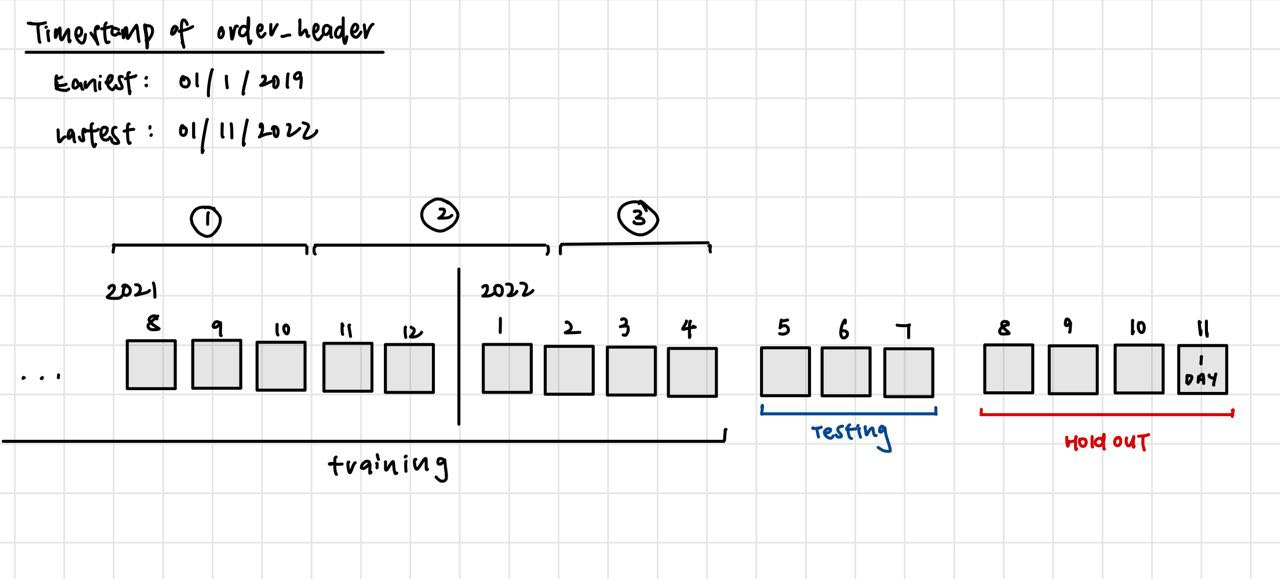

To further help the model train to identify trends better for more accurate prediction, we will be introducing columns that will be based on the customer’s spending, grouped into seasons of 3 months each. 

- Season 1: 2021 Aug to 2021 Oct
- Season 2: 2021 Nov to 2021 Jan
- Season 3: 2022 Feb to 2022 Apr

In [77]:
# Lastest transaction date in order_till_apr2022
lastest_transaction = order_till_2022apr.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
lastest_transaction

datetime.datetime(2022, 4, 30, 22, 56, 19)

In [78]:
# create new column for calculation of datediff which is useful for subsequent steps
order_till_2022apr =  order_till_2022apr.with_column("LAST_ORDER", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction, lastest_transaction))

#### Sales generated for season 1 (2021 Aug to 2021 Oct)

In [79]:
# Get season 1 data
season1 = order_till_2022apr.filter(
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) > 5) & 
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) <= 8))
season1.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"LAST_DATE"          |"CUSTOMER_ID_US"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_

In [80]:
# Ensure timeframe is correct 
season1.agg(F.min("ORDER_TS")).show()
season1.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2021-08-01 08:00:20  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2021-10-31 22:59:46  |
-----------------------



In [81]:
#calculating of transactions per customer for season 1 
season1 = season1.group_by("CUSTOMER_ID").agg(F.sum("order_total").alias("ORDER_TOTAL_S1"))
season1.show()

------------------------------------
|"CUSTOMER_ID"  |"ORDER_TOTAL_S1"  |
------------------------------------
|180087         |112.0000          |
|115581         |132.0000          |
|110967         |261.5000          |
|147321         |315.0000          |
|93952          |102.0000          |
|97173          |110.0000          |
|57690          |138.0000          |
|30096          |377.0000          |
|136945         |230.0000          |
|1640           |179.0000          |
------------------------------------



#### Sales generated for season 2 (2021 Nov to 2021 Jan)

In [82]:
# Get season 2 data
season2 = order_till_2022apr.filter(
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) > 2) & 
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) <= 5))
season2.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"LAST_DATE"          |"CUSTOMER_ID_US"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED

In [83]:
# Ensure timeframe is correct
season2.agg(F.min("ORDER_TS")).show()
season2.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2021-11-01 08:02:20  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-01-31 22:46:20  |
-----------------------



In [84]:
#calculating of transactions per customer for season 2 
season2 = season2.group_by("CUSTOMER_ID").agg(F.sum("order_total").alias("ORDER_TOTAL_S2"))
season2.show()

------------------------------------
|"CUSTOMER_ID"  |"ORDER_TOTAL_S2"  |
------------------------------------
|25558          |197.0000          |
|76292          |115.0000          |
|114267         |335.0000          |
|90978          |164.5000          |
|63820          |339.0000          |
|95575          |161.0000          |
|44827          |361.0000          |
|191647         |61.0000           |
|140181         |353.0000          |
|182029         |454.0000          |
------------------------------------



#### Sales generated for seasoon 3 (2022 Feb to 2022 Apr)

In [85]:
# Get season 3 data
season3 = order_till_2022apr.filter(F.datediff("month", F.col("ORDER_TS"), F.col('LAST_ORDER')) <= 2)
season3.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"LAST_DATE"          |"CUSTOMER_ID_US"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"         |"COUNTRY"      |"POSTAL_CODE"  

In [86]:
# Ensure timeframe is correct
season3.agg(F.min('ORDER_TS')).show()
season3.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-02-01 08:00:13  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-04-30 22:56:19  |
-----------------------



In [87]:
#calculating of transactions per customer for season 3 
season3 = season3.group_by("CUSTOMER_ID").agg(F.sum("order_total").alias("ORDER_TOTAL_S3"))
season3.show()

------------------------------------
|"CUSTOMER_ID"  |"ORDER_TOTAL_S3"  |
------------------------------------
|194624         |338.0000          |
|14987          |140.0000          |
|90972          |192.0000          |
|88929          |278.7500          |
|165208         |574.5000          |
|20354          |276.7500          |
|155692         |90.0000           |
|64216          |239.0000          |
|168481         |436.0000          |
|157101         |263.0000          |
------------------------------------



In [88]:
season3.count()

46152

#### Joining them into a dataframe

In [89]:
# joining of all season columns into a dataframe
order_till_2022apr_with_feature_engineering = us_customer_df.join(season1, us_customer_df.CUSTOMER_ID == season1.CUSTOMER_ID, how = "left", lsuffix = "", rsuffix = "_S1")
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.join(season2, season2.CUSTOMER_ID == order_till_2022apr_with_feature_engineering.CUSTOMER_ID, how = "left", lsuffix = "", rsuffix = "_S2")
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.join(season3, season3.CUSTOMER_ID == order_till_2022apr_with_feature_engineering.CUSTOMER_ID, how = "left", lsuffix = "", rsuffix = "_S3")

# Remove unnecessary columns
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.drop("CUSTOMER_ID_S1", "CUSTOMER_ID_S2", "CUSTOMER_ID_S3")
order_till_2022apr_with_feature_engineering.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CITY_FREQUENCY"  |"ORDER_TOTAL_S1"  |"ORDER_TOTAL_S2"  |"ORDER_TOTAL_S3"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|90972          |2157.5000      |2.235616         |965.0584000115    |26.390937             |59             |19              |10016             |496.0000          |137.0000          |192.0000          |
|126883         |3051.0000      |2.252055         |1354.7626501129   |34.635033             |78             |5               |10016             |456.0000          |259.0000          |468.5

#### Calculate change in seasons

In [90]:
# Replace null values 
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.with_column("ORDER_TOTAL_S1", F.iff(F.col("ORDER_TOTAL_S1").is_null(), 0, F.col("ORDER_TOTAL_S1")))
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.with_column("ORDER_TOTAL_S2", F.iff(F.col("ORDER_TOTAL_S2").is_null(), 0, F.col("ORDER_TOTAL_S2")))
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.with_column("ORDER_TOTAL_S3", F.iff(F.col("ORDER_TOTAL_S3").is_null(), 0, F.col("ORDER_TOTAL_S3")))

# calculating season on season change 
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.with_column("CHANGE_FROM_S1_TO_S2", F.iff(F.col("ORDER_TOTAL_S1")==0, 0, ((F.col("ORDER_TOTAL_S2")-F.col("ORDER_TOTAL_S1"))/F.col("ORDER_TOTAL_S1"))*100))
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.with_column("CHANGE_FROM_S2_TO_S3", F.iff(F.col("ORDER_TOTAL_S2")==0, 0, ((F.col("ORDER_TOTAL_S3")-F.col("ORDER_TOTAL_S2"))/F.col("ORDER_TOTAL_S2"))*100))

## 6.2 RFM Clustering <a id="part6-2"></a>

In [91]:
# Convert to pandas for modelling
order_till_2022apr_with_feature_engineering = order_till_2022apr_with_feature_engineering.to_pandas()

### 6.2.1 Recency <a id="part6-2-1"></a>

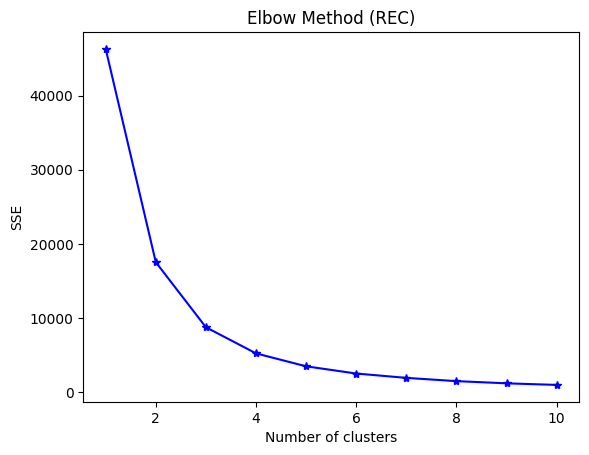

In [92]:
# K-Means Clustering
#k-means
sse=[]
scaler = StandardScaler() 
recency = order_till_2022apr_with_feature_engineering[['RECENCY_DAYS']].to_numpy()
X_scaled = scaler.fit_transform(recency) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (REC)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [93]:
# Build 2 Recency Clusters and add it to dataframe 
kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
#tempCustRec = tempCustRec.to_pandas()
kmeans.fit(order_till_2022apr_with_feature_engineering[['RECENCY_DAYS']])
order_till_2022apr_with_feature_engineering['CUST_REC_CLUSTER'] = kmeans.predict(order_till_2022apr_with_feature_engineering[['RECENCY_DAYS']])


#function for ordering cluster numbers

def order_cluster(cluster_field_name, target_field_name,data,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    data_new['index'] = data_new.index
    data_final = pd.merge(data,data_new[[cluster_field_name,'index']], on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name],axis=1)
    data_final = data_final.rename(columns={"index":cluster_field_name})

    return data_final

order_till_2022apr_with_feature_engineering = order_cluster('CUST_REC_CLUSTER', 'RECENCY_DAYS',order_till_2022apr_with_feature_engineering,False)
#see details of the clusters
order_till_2022apr_with_feature_engineering.groupby('CUST_REC_CLUSTER')['RECENCY_DAYS'].describe()


,count,mean,std,min,25%,50%,75%,max
CUST_REC_CLUSTER,,,,,,,,
0,8070.0,39.743990,16.20541,25.0,28.0,35.0,45.0,169.0
1,38230.0,9.325216,6.54102,1.0,4.0,8.0,14.0,24.0


### 6.2.2 Frequency <a id="part6-2-2"></a>

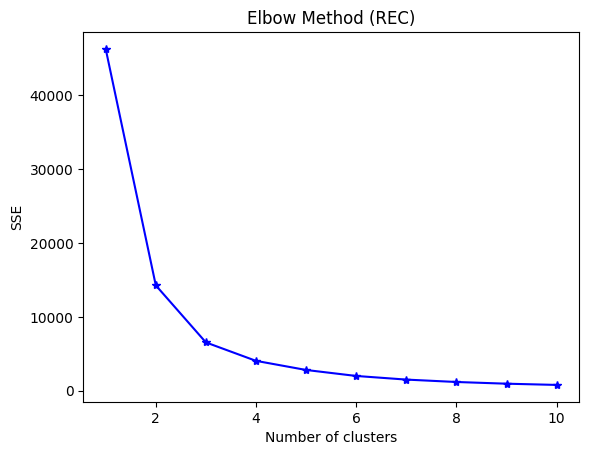

In [94]:
# K-Means Clustering
#k-means
sse=[]
scaler = StandardScaler() 
recency = order_till_2022apr_with_feature_engineering[['CUSTOMER_FREQUENCY']].to_numpy()
X_scaled = scaler.fit_transform(recency) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (REC)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [95]:
#build 2 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
kmeans.fit(order_till_2022apr_with_feature_engineering[['CUSTOMER_FREQUENCY']])
order_till_2022apr_with_feature_engineering['CUST_FREQ_CLUSTER'] = kmeans.predict(order_till_2022apr_with_feature_engineering[['CUSTOMER_FREQUENCY']])


# reuse function for ordering cluster numbers
rfm_df = order_cluster('CUST_FREQ_CLUSTER', 'CUSTOMER_FREQUENCY',order_till_2022apr_with_feature_engineering,True)
#see details of the clusters
order_till_2022apr_with_feature_engineering.groupby('CUST_FREQ_CLUSTER')['CUSTOMER_FREQUENCY'].describe()

,count,unique,top,freq
CUST_FREQ_CLUSTER,,,,
0,31914,8050,24.047060,42
1,14386,6919,19.210526,20


### 6.2.3 Monetary <a id="part6-2-3"></a>

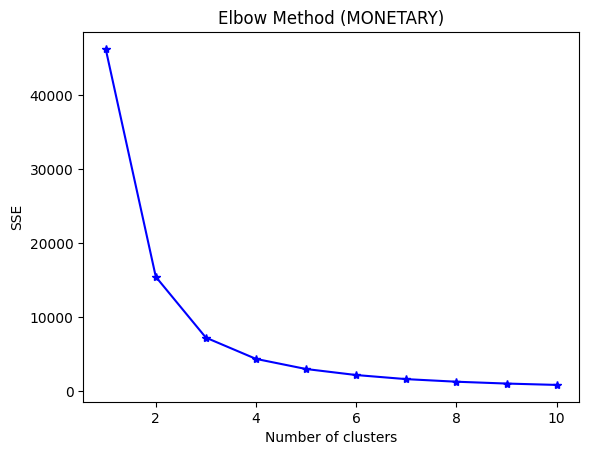

In [96]:
#k-means
sse=[]
scaler = StandardScaler() 
monetary = order_till_2022apr_with_feature_engineering[['MONETARY_VALUE']]
X_scaled = scaler.fit_transform(monetary) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (MONETARY)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [97]:
#build 2 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
kmeans.fit(order_till_2022apr_with_feature_engineering[['MONETARY_VALUE']])
order_till_2022apr_with_feature_engineering['CUST_MONETARY_CLUSTER'] = kmeans.predict(order_till_2022apr_with_feature_engineering[['MONETARY_VALUE']])


# reuse function for ordering cluster numbers
order_till_2022apr_with_feature_engineering = order_cluster('CUST_MONETARY_CLUSTER', 'MONETARY_VALUE',order_till_2022apr_with_feature_engineering,True)
order_till_2022apr_with_feature_engineering.groupby("CUST_MONETARY_CLUSTER")["MONETARY_VALUE"].describe()

,count,unique,top,freq
CUST_MONETARY_CLUSTER,,,,
0,16646,16512,727.7852736659,3
1,29654,29024,991.8525539739,4


In [98]:
# Final Dataframe for orders till 2022 april
order_till_2022apr_with_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_ID            46300 non-null  int32  
 1   TOTAL_SPENT            46300 non-null  float64
 2   YEARS_WITH_US          46300 non-null  float64
 3   MONETARY_VALUE         46300 non-null  object 
 4   CUSTOMER_FREQUENCY     46300 non-null  object 
 5   TOTAL_ORDER            46300 non-null  int64  
 6   RECENCY_DAYS           46300 non-null  int32  
 7   CITY_FREQUENCY         46300 non-null  int64  
 8   ORDER_TOTAL_S1         46300 non-null  float64
 9   ORDER_TOTAL_S2         46300 non-null  float64
 10  ORDER_TOTAL_S3         46300 non-null  float64
 11  CHANGE_FROM_S1_TO_S2   46300 non-null  object 
 12  CHANGE_FROM_S2_TO_S3   46300 non-null  object 
 13  CUST_REC_CLUSTER       46300 non-null  int64  
 14  CUST_FREQ_CLUSTER      46300 non-null  int32  
 15  CU

### 6.2.4 Creating Target Variables <a id="part6-2-4"></a>

In [99]:
# Calculate overall score of customer based on their RFM
order_till_2022apr_with_feature_engineering['OVERALL_SCORE'] = order_till_2022apr_with_feature_engineering['CUST_REC_CLUSTER'] + order_till_2022apr_with_feature_engineering['CUST_FREQ_CLUSTER'] + order_till_2022apr_with_feature_engineering['CUST_MONETARY_CLUSTER']

# Evaluation
order_till_2022apr_with_feature_engineering.groupby('OVERALL_SCORE')[['RECENCY_DAYS','CUSTOMER_FREQUENCY','MONETARY_VALUE']].max()

,RECENCY_DAYS,CUSTOMER_FREQUENCY,MONETARY_VALUE
OVERALL_SCORE,,,
0,117,26.963061,795.4174495747
1,169,39.522292,1622.1575916510
2,134,40.103502,1689.7572305526
3,24,20.191493,1101.1063870191


#### Calculating Target Variable (MONETARY_M3) for test data

In [100]:
# Creating testing dataframe (2022 May to 2022 Jul; three months of data)
orders_testing_ho = order_header_df.filter(F.col("ORDER_TS").between('2022-05-01 00:00:00',('2022-11-01 23:59:59')))
orders_testing = orders_testing_ho.filter(F.col("ORDER_TS").between('2022-05-01 00:00:00',('2022-07-31 23:59:59')))

# Check if timeframe in the dataset is correct
orders_testing.agg(F.min("ORDER_TS")).show()
orders_testing.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-05-01 08:00:00  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-07-31 23:00:00  |
-----------------------



In [101]:
order_till_2022apr_with_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_ID            46300 non-null  int32  
 1   TOTAL_SPENT            46300 non-null  float64
 2   YEARS_WITH_US          46300 non-null  float64
 3   MONETARY_VALUE         46300 non-null  object 
 4   CUSTOMER_FREQUENCY     46300 non-null  object 
 5   TOTAL_ORDER            46300 non-null  int64  
 6   RECENCY_DAYS           46300 non-null  int32  
 7   CITY_FREQUENCY         46300 non-null  int64  
 8   ORDER_TOTAL_S1         46300 non-null  float64
 9   ORDER_TOTAL_S2         46300 non-null  float64
 10  ORDER_TOTAL_S3         46300 non-null  float64
 11  CHANGE_FROM_S1_TO_S2   46300 non-null  object 
 12  CHANGE_FROM_S2_TO_S3   46300 non-null  object 
 13  CUST_REC_CLUSTER       46300 non-null  int64  
 14  CUST_FREQ_CLUSTER      46300 non-null  int32  
 15  CU

In [102]:
# Filtering of customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")

# After filtering of customer dataset to only US, we will be filtering and looking at the orders 
# based on these customers only
customer_US = us_customer_df.select(F.col("CUSTOMER_ID"))
orders_testing = orders_testing.join(customer_US, orders_testing.CUSTOMER_ID == customer_US.CUSTOMER_ID, lsuffix = "", rsuffix = "_US")

In [103]:
# Calculate monetary value of customers within that three months timeframe 
orders_testing = orders_testing.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("MONETARY_M3"))
orders_testing = orders_testing.to_pandas()

# Merge with our dataframe
final_df = pd.merge(order_till_2022apr_with_feature_engineering, orders_testing, on="CUSTOMER_ID",how='left')

In [104]:
# Impute null values in target variable as 0
final_df = final_df.fillna(0)

# Check final_df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_ID            46300 non-null  int32  
 1   TOTAL_SPENT            46300 non-null  float64
 2   YEARS_WITH_US          46300 non-null  float64
 3   MONETARY_VALUE         46300 non-null  object 
 4   CUSTOMER_FREQUENCY     46300 non-null  object 
 5   TOTAL_ORDER            46300 non-null  int64  
 6   RECENCY_DAYS           46300 non-null  int32  
 7   CITY_FREQUENCY         46300 non-null  int64  
 8   ORDER_TOTAL_S1         46300 non-null  float64
 9   ORDER_TOTAL_S2         46300 non-null  float64
 10  ORDER_TOTAL_S3         46300 non-null  float64
 11  CHANGE_FROM_S1_TO_S2   46300 non-null  object 
 12  CHANGE_FROM_S2_TO_S3   46300 non-null  object 
 13  CUST_REC_CLUSTER       46300 non-null  int64  
 14  CUST_FREQ_CLUSTER      46300 non-null  int32  
 15  CU

In [105]:
# Correlation between features
final_df.corr()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,TOTAL_ORDER,RECENCY_DAYS,CITY_FREQUENCY,ORDER_TOTAL_S1,ORDER_TOTAL_S2,ORDER_TOTAL_S3,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,MONETARY_M3
CUSTOMER_ID,1.000000,0.070479,-0.034993,0.088198,-0.015833,-0.188449,0.018474,0.026478,0.028840,0.016639,-0.089194,0.071124,-0.001703,0.021774
TOTAL_SPENT,0.070479,1.000000,-0.132843,0.898641,-0.123997,-0.426141,0.421682,0.440132,0.364237,0.091738,-0.640495,0.729675,0.180464,0.444963
YEARS_WITH_US,-0.034993,-0.132843,1.000000,-0.176154,0.116302,0.160558,-0.073140,-0.082623,-0.194290,-0.090077,0.547152,-0.459989,-0.003443,-0.102676
TOTAL_ORDER,0.088198,0.898641,-0.176154,1.000000,-0.151158,-0.508742,0.369344,0.386140,0.327389,0.112880,-0.723656,0.696855,0.086262,0.383742
RECENCY_DAYS,-0.015833,-0.123997,0.116302,-0.151158,1.000000,0.064281,-0.006593,-0.018481,-0.343099,-0.788364,0.149536,-0.131684,-0.597376,-0.029545
CITY_FREQUENCY,-0.188449,-0.426141,0.160558,-0.508742,0.064281,1.000000,-0.109824,-0.157477,-0.159145,-0.054170,0.469936,-0.388096,0.021805,-0.136418
ORDER_TOTAL_S1,0.018474,0.421682,-0.073140,0.369344,-0.006593,-0.109824,1.000000,0.089922,0.058262,0.008310,-0.263928,0.309956,0.060634,0.083542
ORDER_TOTAL_S2,0.026478,0.440132,-0.082623,0.386140,-0.018481,-0.157477,0.089922,1.000000,0.061163,0.012039,-0.282178,0.324742,0.060765,0.095451
ORDER_TOTAL_S3,0.028840,0.364237,-0.194290,0.327389,-0.343099,-0.159145,0.058262,0.061163,1.000000,0.275918,-0.293411,0.321578,0.251129,0.058308
CUST_REC_CLUSTER,0.016639,0.091738,-0.090077,0.112880,-0.788364,-0.054170,0.008310,0.012039,0.275918,1.000000,-0.112386,0.096889,0.762043,0.019565


In [106]:
# Create cluster
kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
kmeans.fit(final_df[['MONETARY_M3']])
final_df['LTVCluster'] = kmeans.predict( final_df[['MONETARY_M3']])

#order cluster number based on LTV
final_df = order_cluster('LTVCluster', 'MONETARY_M3', final_df,True)

#creatinga new cluster dataframe
df_cluster = final_df.copy()

#see details of the clusters
df_cluster.groupby('LTVCluster')['MONETARY_M3'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,28218.0,189.849608,68.659801,0.00,141.0,197.0,246.75,297.50
1,18082.0,406.032297,90.986461,297.75,336.5,383.0,452.75,977.25


In [107]:
# FINAL dataframe
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_ID            46300 non-null  int32  
 1   TOTAL_SPENT            46300 non-null  float64
 2   YEARS_WITH_US          46300 non-null  float64
 3   MONETARY_VALUE         46300 non-null  object 
 4   CUSTOMER_FREQUENCY     46300 non-null  object 
 5   TOTAL_ORDER            46300 non-null  int64  
 6   RECENCY_DAYS           46300 non-null  int32  
 7   CITY_FREQUENCY         46300 non-null  int64  
 8   ORDER_TOTAL_S1         46300 non-null  float64
 9   ORDER_TOTAL_S2         46300 non-null  float64
 10  ORDER_TOTAL_S3         46300 non-null  float64
 11  CHANGE_FROM_S1_TO_S2   46300 non-null  object 
 12  CHANGE_FROM_S2_TO_S3   46300 non-null  object 
 13  CUST_REC_CLUSTER       46300 non-null  int64  
 14  CUST_FREQ_CLUSTER      46300 non-null  int32  
 15  CU

In [108]:
df_cluster['MONETARY_VALUE'] = df_cluster['MONETARY_VALUE'].astype("float")
df_cluster['CUSTOMER_FREQUENCY'] = df_cluster['CUSTOMER_FREQUENCY'].astype("float")
df_cluster['CHANGE_FROM_S1_TO_S2'] = df_cluster['CHANGE_FROM_S1_TO_S2'].astype("float")
df_cluster['CHANGE_FROM_S2_TO_S3'] = df_cluster['CHANGE_FROM_S2_TO_S3'].astype("float")

## 6.3 Building Model <a id="part6-3"></a>

In [109]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#convert categorical columns to numerical
#DF_class = pd.get_dummies(DF_cluster)

#calculate and show correlations
corr_matrix = df_cluster.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

'''
#create X and y, X will be feature set and y is the label - LTV
X = df_cluster.drop(['MONETARY_M3','CUSTOMER_ID','LTVCluster'],axis=1)
y = df_cluster['LTVCluster']
'''

"\n#create X and y, X will be feature set and y is the label - LTV\nX = df_cluster.drop(['MONETARY_M3','CUSTOMER_ID','LTVCluster'],axis=1)\ny = df_cluster['LTVCluster']\n"

## 6.2. Upload to FrostyByte 

In [110]:
X = df_cluster
y = df_cluster[['LTVCluster']]

In [111]:
# Get account credentials from a json file
with open("account.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    #"warehouse": "tasty_ds_wh",
    "database": "FROSTBYTE_TASTY_BYTES",
    "schema": "analytics",
}

# Create Snowpark session
sessionWrite = Session.builder.configs(connection_parameters).create()

X = sessionWrite.create_dataframe(X)
y = sessionWrite.create_dataframe(y)
# Save X data
X.write.mode("overwrite").save_as_table("FROSTBYTE_TASTY_BYTES.ANALYTICS.TRAIN_UPLIFT_3M")

# Save y data
y.write.mode("overwrite").save_as_table("FROSTBYTE_TASTY_BYTES.ANALYTICS.TRAIN_TARGET_3M")

## 6.3.2. Loading from FrostyBtye

In [112]:
# Import Python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import sys
import cachetools
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt 
import seaborn as sns
import math

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col

# Clustering & Model
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Scalers
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# find the best combination of model hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# Getting Password,Username, Account
import getpass
# Get account credentials from a json file
with open("account.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    #"warehouse": "tasty_ds_wh",
    #"database": "FROSTBYTE_TASTY_BYTES",
    #"schema": "analytics",
}

# Create Snowpark session
sessionLoad = Session.builder.configs(connection_parameters).create()

In [113]:
# Load the database
X = sessionLoad.table("FROSTBYTE_TASTY_BYTES.ANALYTICS.TRAIN_UPLIFT_3M")
X_load = X.to_pandas()

y = sessionLoad.table("FROSTBYTE_TASTY_BYTES.ANALYTICS.TRAIN_TARGET_3M")
y_load = y.to_pandas()
y_load = y_load['LTVCluster']
# Dropping of unwanted columns
X_load = X_load.drop(columns=['CUSTOMER_ID','MONETARY_M3','LTVCluster'])

In [114]:
#create X and y, X will be feature set and y is the label - LTV
X = df_cluster.drop(['MONETARY_M3','CUSTOMER_ID','LTVCluster'],axis=1)
y = df_cluster['LTVCluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [115]:
# Checking of rows and columns for train and test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32410, 16), (13890, 16), (32410,), (13890,))

In [116]:
X_train.columns.to_list()

['TOTAL_SPENT',
 'YEARS_WITH_US',
 'MONETARY_VALUE',
 'CUSTOMER_FREQUENCY',
 'TOTAL_ORDER',
 'RECENCY_DAYS',
 'CITY_FREQUENCY',
 'ORDER_TOTAL_S1',
 'ORDER_TOTAL_S2',
 'ORDER_TOTAL_S3',
 'CHANGE_FROM_S1_TO_S2',
 'CHANGE_FROM_S2_TO_S3',
 'CUST_REC_CLUSTER',
 'CUST_FREQ_CLUSTER',
 'CUST_MONETARY_CLUSTER',
 'OVERALL_SCORE']

In [117]:
y_train

13922    1
4589     1
36261    0
13250    1
3957     1
        ..
11284    1
44732    0
38158    0
860      1
15795    1
Name: LTVCluster, Length: 32410, dtype: int64

In [118]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

xgb = xgb.XGBClassifier()
logreg2= LogisticRegressionCV()
knn = KNeighborsClassifier()
#svcl = SVC()
adb = AdaBoostClassifier()
dtclf = DecisionTreeClassifier()
rfclf = RandomForestClassifier()

# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegressionCV(solver='lbfgs', max_iter=5000, cv=5, multi_class='auto')))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('DT', DecisionTreeClassifier(max_depth=5)))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('ADA', AdaBoostClassifier()))
models.append(('MLP', MLPClassifier(max_iter=1000)))
#models.append(('SVC', SVC(gamma='scale')))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model,X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.679482 (0.007267)
XGB: 0.675532 (0.002253)
KNN: 0.649213 (0.005374)
DT: 0.670626 (0.004618)
RF: 0.677013 (0.008402)
ADA: 0.685375 (0.004464)
MLP: 0.613175 (0.037312)


### Logistic Regression

In [119]:
modelTestResults = pd.DataFrame(columns=['Model','Train_Accuracy', 'Test_Accuracy','Cross_Val_Train_Accuracy','Cross_Val_Test_Accuracy'])

In [120]:
LRModel = LogisticRegressionCV(solver='lbfgs', max_iter=5000, cv=5, multi_class='auto')
LRModel.fit(X_train, y_train)
trainAcc = LRModel.score(X_train,y_train)
testAcc = LRModel.score(X_test,y_test)
print('training accuracy is: ', LRModel.score(X_train,y_train))
print('testing accuracy is: ', LRModel.score(X_test,y_test))

training accuracy is:  0.6791113853748842
testing accuracy is:  0.6758819294456444


#### XG Boost

In [121]:
xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train)
trainAcc = xgbModel.score(X_train,y_train)
testAcc = xgbModel.score(X_test,y_test)
print('training accuracy is: ', xgbModel.score(X_train,y_train))
print('testing accuracy is: ', xgbModel.score(X_test,y_test))

training accuracy is:  0.78895402653502
testing accuracy is:  0.6758099352051836


In [122]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(xgbModel, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'XGBoost','Train_Accuracy': trainAcc, 'Test_Accuracy': testAcc, 'Cross_Val_Train_Accuracy': cv_train_accuracy, 'Cross_Val_Test_Accuracy': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [0.78957883 0.79676026 0.8024838  0.77456803 0.80329374]
test_score:  [0.59330454 0.59568035 0.50583153 0.5925486  0.62062635]
cross val training accuracy is: 0.7933369330453564
cross val testing accuracy is: 0.5815982721382289


#### KNN Classifier

In [123]:
knnModel = KNeighborsClassifier(5)
knnModel.fit(X_train, y_train)
trainAcc = knnModel.score(X_train,y_train)
testAcc = knnModel.score(X_test,y_test)
print('training accuracy is: ', knnModel.score(X_train,y_train))
print('testing accuracy is: ', knnModel.score(X_test,y_test))

training accuracy is:  0.7613699475470533
testing accuracy is:  0.6439884809215263


In [124]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(knnModel, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'K-Nearest Neighbors','Train_Accuracy': trainAcc, 'Test_Accuracy': testAcc, 'Cross_Val_Train_Accuracy': cv_train_accuracy, 'Cross_Val_Test_Accuracy': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [0.77305616 0.76954644 0.76177106 0.74095572 0.7775378 ]
test_score:  [0.56025918 0.56533477 0.61187905 0.6825054  0.6224622 ]
cross val training accuracy is: 0.76457343412527
cross val testing accuracy is: 0.6084881209503239


#### Decision Tree

In [125]:
dtModel = DecisionTreeClassifier(max_depth=5)
dtModel.fit(X_train, y_train)
trainAcc = dtModel.score(X_train,y_train)
testAcc = dtModel.score(X_test,y_test)
print('training accuracy is: ', dtModel.score(X_train,y_train))
print('testing accuracy is: ', dtModel.score(X_test,y_test))

training accuracy is:  0.6784017278617711
testing accuracy is:  0.6670266378689704


In [126]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(dtModel, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'Decision Tree (depth=5)','Train_Accuracy': trainAcc, 'Test_Accuracy': testAcc, 'Cross_Val_Train_Accuracy': cv_train_accuracy, 'Cross_Val_Test_Accuracy': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [0.69800216 0.6962473  0.70421166 0.65955724 0.68941685]
test_score:  [0.58477322 0.57775378 0.51490281 0.58423326 0.61673866]
cross val training accuracy is: 0.6894870410367171
cross val testing accuracy is: 0.5756803455723543


#### Random Forest

In [127]:
rfModel = RandomForestClassifier(n_estimators=100)
rfModel.fit(X_train, y_train)
trainAcc = rfModel.score(X_train,y_train)
testAcc = rfModel.score(X_test,y_test)
print('training accuracy is: ', rfModel.score(X_train,y_train))
print('testing accuracy is: ', rfModel.score(X_test,y_test))

training accuracy is:  1.0
testing accuracy is:  0.6771058315334774


In [128]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(rfModel, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'Random Forest','Train_Accuracy': trainAcc, 'Test_Accuracy': testAcc, 'Cross_Val_Train_Accuracy': cv_train_accuracy, 'Cross_Val_Test_Accuracy': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [1.       0.999973 1.       1.       0.999973]
test_score:  [0.58844492 0.60237581 0.49838013 0.60367171 0.61911447]
cross val training accuracy is: 0.9999892008639308
cross val testing accuracy is: 0.5823974082073434


#### ADA Boost

In [129]:
adaModel = AdaBoostClassifier()
adaModel.fit(X_train, y_train)

trainAcc = adaModel.score(X_train,y_train)
testAcc = adaModel.score(X_test,y_test)
print('training accuracy is: ', adaModel.score(X_train,y_train))
print('testing accuracy is: ', adaModel.score(X_test,y_test))

training accuracy is:  0.6929342795433509
testing accuracy is:  0.6825053995680346


In [130]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(adaModel, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

new_row = {'Model' : 'AdaBoost','Train_Accuracy': trainAcc, 'Test_Accuracy': testAcc, 'Cross_Val_Train_Accuracy': cv_train_accuracy, 'Cross_Val_Test_Accuracy': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [0.70458963 0.70691145 0.70890929 0.67907667 0.70791037]
test_score:  [0.60291577 0.60885529 0.5524838  0.59773218 0.61943844]
cross val training accuracy is: 0.7014794816414687
cross val testing accuracy is: 0.5962850971922247


#### MLP

In [131]:
mlp = MLPClassifier(activation ='logistic', hidden_layer_sizes=(5,), max_iter=2000, solver ='adam', random_state=42)
mlp.fit(X_train,y_train)

trainAcc = mlp.score(X_train,y_train)
testAcc = mlp.score(X_test,y_test)
print(mlp.score(X_train, y_train), '(Train Accuracy)')
print(mlp.score(X_test, y_test), '(Test Accuracy)')

0.6590558469608145 (Train Accuracy)
0.6546436285097192 (Test Accuracy)


In [132]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(mlp, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

new_row = {'Model' : 'Multi-layer Perceptron','Train_Accuracy': trainAcc, 'Test_Accuracy': testAcc, 'Cross_Val_Train_Accuracy': cv_train_accuracy, 'Cross_Val_Test_Accuracy': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [0.6437365  0.63207343 0.6174946  0.61968143 0.65766739]
test_score:  [0.45205184 0.44233261 0.57969762 0.63293737 0.63542117]
cross val training accuracy is: 0.6341306695464364
cross val testing accuracy is: 0.548488120950324


In [133]:
# Model Results
modelTestResults

,Model,Train_Accuracy,Test_Accuracy,Cross_Val_Train_Accuracy,Cross_Val_Test_Accuracy
0,XGBoost,0.788954,0.675810,0.793337,0.581598
1,K-Nearest Neighbors,0.761370,0.643988,0.764573,0.608488
2,Decision Tree (depth=5),0.678402,0.667027,0.689487,0.575680
3,Random Forest,1.000000,0.677106,0.999989,0.582397
4,AdaBoost,0.692934,0.682505,0.701479,0.596285
5,Multi-layer Perceptron,0.659056,0.654644,0.634131,0.548488


### GridSearch for Multi-Layer Perceptron and Decision Tree

In [134]:
dtModel_gv = DecisionTreeClassifier(random_state=42)
param_grid = { "criterion" : ["gini", "entropy"],
     "min_samples_leaf" : [1, 5, 10],
     "min_samples_split" : [2, 4, 10, 12, 16],
     'max_depth' : [2,3,4,5,6,7,8,9,10,11]}

gs = GridSearchCV(dtModel_gv, param_grid=param_grid, scoring='accuracy', cv= 5, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.6754088244369022
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [135]:
dtModel_GV = DecisionTreeClassifier(criterion = 'gini', max_depth= 3, min_samples_leaf= 10, min_samples_split= 2)
dtModel_GV.fit(X_train, y_train)
trainAcc = dtModel_GV.score(X_train,y_train)
testAcc = dtModel_GV.score(X_test,y_test)

print('training accuracy is: ', dtModel_GV.score(X_train,y_train))
print('testing accuracy is: ', dtModel_GV.score(X_test,y_test))
# Evaluate the Model using K-folds Cross validation
results = cross_validate(dtModel_GV, X_load, y_load, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'Decision Tree (GS)','Train_Accuracy': trainAcc, 'Test_Accuracy': testAcc, 'Cross_Val_Train_Accuracy': cv_train_accuracy, 'Cross_Val_Test_Accuracy': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

training accuracy is:  0.6722925023141005
testing accuracy is:  0.6706983441324694
train_score:  [0.69098272 0.68812095 0.68704104 0.64894708 0.6825054 ]
test_score:  [0.58660907 0.60604752 0.5600432  0.67030238 0.61803456]
cross val training accuracy is: 0.6795194384449245
cross val testing accuracy is: 0.608207343412527


In [136]:
# Use GridSearch to find the best combination of model hyperparameters
mlp_gv = MLPClassifier(random_state=42)
param_grid = { "activation" : ["logistic", "relu"],
 "hidden_layer_sizes" : [(5,), (10,), (20,)],
 "max_iter" : [200, 2000, 4000],
 "solver" : ["sgd", "adam"]}

gs = GridSearchCV(mlp_gv, param_grid=param_grid, scoring='accuracy', cv= 5, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.6496143165689603
{'activation': 'logistic', 'hidden_layer_sizes': (20,), 'max_iter': 200, 'solver': 'adam'}


In [137]:
mlp_GV = MLPClassifier(activation = 'logistic', hidden_layer_sizes= (5,), max_iter= 200, solver= 'sgd')
mlp_GV.fit(X_train, y_train)
trainAcc = mlp_GV.score(X_train,y_train)
testAcc = mlp_GV.score(X_test,y_test)

print('training accuracy is: ', mlp_GV.score(X_train,y_train))
print('testing accuracy is: ', mlp_GV.score(X_test,y_test))
# Evaluate the Model using K-folds Cross validation
results = cross_validate(mlp_GV, X_load, y_load, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'MLP (GS)','Train_Accuracy': trainAcc, 'Test_Accuracy': testAcc, 'Cross_Val_Train_Accuracy': cv_train_accuracy, 'Cross_Val_Test_Accuracy': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

training accuracy is:  0.6101511879049676
testing accuracy is:  0.6078473722102232
train_score:  [0.60953024 0.60947624 0.60944924 0.60944924 0.60944924]
test_score:  [0.60939525 0.60939525 0.60950324 0.60950324 0.60950324]
cross val training accuracy is: 0.6094708423326134
cross val testing accuracy is: 0.6094600431965442


In [138]:
# Dataframe for accuracy of each model
modelTestResults

,Model,Train_Accuracy,Test_Accuracy,Cross_Val_Train_Accuracy,Cross_Val_Test_Accuracy
0,XGBoost,0.788954,0.675810,0.793337,0.581598
1,K-Nearest Neighbors,0.761370,0.643988,0.764573,0.608488
2,Decision Tree (depth=5),0.678402,0.667027,0.689487,0.575680
3,Random Forest,1.000000,0.677106,0.999989,0.582397
4,AdaBoost,0.692934,0.682505,0.701479,0.596285
5,Multi-layer Perceptron,0.659056,0.654644,0.634131,0.548488
6,Decision Tree (GS),0.672293,0.670698,0.679519,0.608207
7,MLP (GS),0.610151,0.607847,0.609471,0.609460


### Holdout Data

Redo all steps for dataframe with timeframe of 2019 June to 2022 Jul.

In [139]:
# Create dataframe (2019 June to 2022 Jul ; exclude last 3 months + 1 day of data)
order_till_2022jul = order_header_df.filter(F.col("ORDER_TS").between('2019-01-01 00:00:00',('2022-07-31 23:59:59')))

# Check if the timeframe in the dataset is correct
# Show min & max order timestamp after filtering
order_till_2022jul.agg(F.min("ORDER_TS")).show()
order_till_2022jul.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 08:00:07  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-07-31 23:00:00  |
-----------------------



In [140]:
# Filtering of customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")

# Encoding for customer's city
# city [Frequency Encoding]
us_customer_df.group_by("CITY").agg(F.count("CUSTOMER_ID").alias("CID"))
freq_enc = us_customer_df.groupBy("CITY").agg(F.count("CUSTOMER_ID").alias("city_frequency"))
    # join the encoded column back to the original DataFrame
us_customer_df = us_customer_df.join(freq_enc, us_customer_df.CITY == freq_enc.CITY, lsuffix = "", rsuffix = "_FREQ_ENC")

# only customer's city is needed
us_customer_df = us_customer_df.select("CUSTOMER_ID", "CITY_FREQUENCY")

##### Calculate Recency

In [141]:
customer_last_order_timestamp = order_till_2022jul.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))

# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Inserting new column: current date which the lastest transaction timestamp
customer_recency = customer_last_order_timestamp.with_column("CURRENT DATE", F.iff(F.col("LAST_ORDER_TS") == F.col("LAST_ORDER_TS"), "2022-08-01", "0"))

# Calculate recency days
customer_recency = customer_recency.with_column("RECENCY_DAYS", F.datediff('day', customer_recency["LAST_ORDER_TS"], customer_recency["CURRENT DATE"]))
customer_recency.show()

-------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"CURRENT DATE"  |"RECENCY_DAYS"  |
-------------------------------------------------------------------------
|NULL           |2022-07-31 23:00:00  |2022-08-01      |1               |
|30829          |2022-07-31 15:10:01  |2022-08-01      |1               |
|4568           |2022-07-21 18:30:27  |2022-08-01      |11              |
|5260           |2022-07-07 17:19:09  |2022-08-01      |25              |
|61005          |2022-07-29 08:32:15  |2022-08-01      |3               |
|10363          |2022-07-29 19:24:23  |2022-08-01      |3               |
|43799          |2022-07-26 16:48:18  |2022-08-01      |6               |
|200839         |2022-07-29 21:08:21  |2022-08-01      |3               |
|3843           |2022-07-19 12:14:21  |2022-08-01      |13              |
|200793         |2022-07-31 08:19:56  |2022-08-01      |1               |
--------------------------------------

In [142]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency = customer_recency.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
us_customer_df = temp_customer_recency.join(us_customer_df, 
                                us_customer_df.CUSTOMER_ID==temp_customer_recency.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

# Drop uneccessary columns created when joining 
us_customer_df = us_customer_df.drop("CUSTOMER_ID_RECENCY")

##### Calculate Frequency

In [143]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp = order_header_df.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|NULL           |2019-01-01 08:00:07  |
|216851         |2019-10-19 17:58:07  |
|204640         |2019-11-30 10:22:44  |
|9475           |2019-10-14 19:21:56  |
|6712           |2019-11-22 12:42:28  |
---------------------------------------



In [144]:
# Calculating the total number of orders for each customer
total_order_by_cust = order_header_df.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|NULL           |234837284      |
|190702         |63             |
|97913          |72             |
|93938          |53             |
|85897          |60             |
---------------------------------



In [145]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq = customer_df.join(customer_first_order_timestamp, customer_df.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq = customer_freq.join(total_order_by_cust, customer_freq.CUSTOMER_ID==total_order_by_cust.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq = customer_freq.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-08-01", "0"))
customer_freq = customer_freq.with_column("YEARS_WITH_US",F.datediff("day", customer_freq["FIRST_ORDER_TS"], customer_freq["CURRENT DATE"])/365)
customer_freq = customer_freq.with_column("CUSTOMER_FREQUENCY", customer_freq["TOTAL_ORDER"]/customer_freq["YEARS_WITH_US"])

In [146]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq = customer_freq.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
us_customer_df = temp_customer_freq.join(us_customer_df, 
                                us_customer_df.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")
# Drop uneccessary columns created when joining 
us_customer_df = us_customer_df.drop("CUSTOMER_ID_FREQUENCY")

##### Calculate Monetary

In [147]:
 # Calculate the total sales generated by each customer 
total_amount_spent = order_header_df.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary = total_amount_spent.join(customer_first_order_timestamp, total_amount_spent.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary = customer_monetary.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-08-01", "0"))
customer_monetary = customer_monetary.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary["FIRST_ORDER_TS"], customer_monetary["CURRENT DATE"])/365)
customer_monetary = customer_monetary.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [148]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_freq = customer_monetary.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
us_customer_df = temp_customer_freq.join(us_customer_df, us_customer_df.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")
# Drop uneccessary columns created when joining 
us_customer_df = us_customer_df.drop("CUSTOMER_ID_MONETARY")
us_customer_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CITY_FREQUENCY"  |
-------------------------------------------------------------------------------------------------------------------------------------------------
|183970         |3181.2500      |2.402740         |1324.0092560993   |31.630555             |76             |1               |10016             |
|29824          |2351.2500      |2.567123         |915.9085871616    |24.151550             |62             |10              |10016             |
|140929         |2081.2500      |2.561644         |812.4665254032    |22.251335             |57             |2               |10016             |
|136876         |2545.5000      |2.528767         |1006.6170588275   |28.472374             |72             |4              

##### Feature Engineering - Adding of seasons 

In [149]:
# Lastest transaction date in order_till_2022jul
lastest_transaction = order_till_2022jul.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
lastest_transaction

datetime.datetime(2022, 7, 31, 23, 0)

In [150]:
# create new column for calculation of datediff which is useful for subsequent steps
order_till_2022jul =  order_till_2022jul.with_column("LAST_ORDER", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction, lastest_transaction))

#### Sales generated for season 1 (2021 Nov to 2022 Jan)

In [151]:
# Get season 1 data
season1 = order_till_2022jul.filter(
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) > 5) & 
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) <= 8))
season1.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"LAST_ORDER"         |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|125090832   |271         |10074.0        |NULL           |NULL           |289682      |

In [152]:
# Ensure timeframe is correct 
season1.agg(F.min('ORDER_TS')).show()
season1.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2021-11-01 08:00:00  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-01-31 22:59:59  |
-----------------------



In [153]:
#calculating of transactions per customer for season 1 
season1 = season1.group_by("CUSTOMER_ID").agg(F.sum("order_total").alias("ORDER_TOTAL_S1"))
season1.show()

------------------------------------
|"CUSTOMER_ID"  |"ORDER_TOTAL_S1"  |
------------------------------------
|65291          |186.5000          |
|NULL           |1101761942.5000   |
|118191         |299.0000          |
|116489         |171.5000          |
|153754         |108.0000          |
|154691         |162.5000          |
|21449          |114.0000          |
|138590         |378.0000          |
|9093           |218.0000          |
|143920         |100.5000          |
------------------------------------



#### Sales generated for season 2 (2022 Feb to 2022 Apr)

In [154]:
# Get season 2 data
season2 = order_till_2022jul.filter(
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) > 2) & 
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) <= 5))
season2.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"LAST_ORDER"         |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|403869687   |399         |13574.0        |NULL           |NULL           |200444741   |

In [155]:
# Ensure timeframe is correct 
season2.agg(F.min("ORDER_TS")).show()
season2.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-02-01 08:00:00  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-04-30 23:00:00  |
-----------------------



In [156]:
#calculating of transactions per customer for season 1 
season2 = season2.group_by("CUSTOMER_ID").agg(F.sum("order_total").alias("ORDER_TOTAL_S2"))
season2.show()

------------------------------------
|"CUSTOMER_ID"  |"ORDER_TOTAL_S2"  |
------------------------------------
|212594         |385.0000          |
|3492           |206.5000          |
|212722         |26.0000           |
|219187         |551.5000          |
|3293           |652.2500          |
|206628         |621.0000          |
|7244           |344.5000          |
|218958         |273.0000          |
|10467          |286.5000          |
|218839         |259.0000          |
------------------------------------



#### Sales generated for season 3 (2022 May to 2022 Jul)

In [157]:
# Get season 3 data
season3 = order_till_2022jul.filter(
    (F.datediff("month", F.col("ORDER_TS"), F.col("LAST_ORDER")) < 3))
season3.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"LAST_ORDER"         |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|414688536   |406         |11896.0        |NULL           |NULL           |200466326   |

In [158]:
# Ensure timeframe is correct
season3.agg(F.min('ORDER_TS')).show()
season3.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-05-01 08:00:00  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-07-31 23:00:00  |
-----------------------



In [159]:
#calculating of transactions per customer for season 2 
season3 = season3.group_by("CUSTOMER_ID").agg(F.sum("order_total").alias("ORDER_TOTAL_S3"))
season3.show()

------------------------------------
|"CUSTOMER_ID"  |"ORDER_TOTAL_S3"  |
------------------------------------
|84419          |522.5000          |
|72829          |271.5000          |
|100481         |307.0000          |
|178494         |213.5000          |
|162881         |516.0000          |
|108094         |353.5000          |
|81943          |293.0000          |
|179070         |413.0000          |
|74491          |414.5000          |
|79274          |206.0000          |
------------------------------------



##### Joining them into a dataframe

In [160]:
us_customer_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CITY_FREQUENCY"  |
-------------------------------------------------------------------------------------------------------------------------------------------------
|183970         |3181.2500      |2.402740         |1324.0092560993   |31.630555             |76             |1               |10016             |
|29824          |2351.2500      |2.567123         |915.9085871616    |24.151550             |62             |10              |10016             |
|140929         |2081.2500      |2.561644         |812.4665254032    |22.251335             |57             |2               |10016             |
|136876         |2545.5000      |2.528767         |1006.6170588275   |28.472374             |72             |4              

In [161]:
# joining of all season columns into a dataframe
order_till_2022jul_with_feature_engineering = us_customer_df.join(season1, us_customer_df.CUSTOMER_ID == season1.CUSTOMER_ID, how = "left", lsuffix = "", rsuffix = "_S1")
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.join(season2, season2.CUSTOMER_ID == order_till_2022jul_with_feature_engineering.CUSTOMER_ID, how = "left", lsuffix = "", rsuffix = "_S2")
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.join(season3, season3.CUSTOMER_ID == order_till_2022jul_with_feature_engineering.CUSTOMER_ID, how = "left", lsuffix = "", rsuffix = "_S3")

# Remove unnecessary columns
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.drop("CUSTOMER_ID_S1", "CUSTOMER_ID_S2", "CUSTOMER_ID_S3")
order_till_2022jul_with_feature_engineering.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CITY_FREQUENCY"  |"ORDER_TOTAL_S1"  |"ORDER_TOTAL_S2"  |"ORDER_TOTAL_S3"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|21363          |2425.0000      |2.536986         |955.8586448644    |24.044279             |61             |2               |9261              |214.0000          |426.5000          |237.5000          |
|77815          |2418.7500      |2.490411         |971.2252314979    |23.690869             |59             |4               |9261              |221.5000          |211.0000          |323.0

#### Calculate change in seasons

In [162]:
# Replace null values 
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.with_column("ORDER_TOTAL_S1", F.iff(F.col("ORDER_TOTAL_S1").is_null(), 0, F.col("ORDER_TOTAL_S1")))
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.with_column("ORDER_TOTAL_S2", F.iff(F.col("ORDER_TOTAL_S2").is_null(), 0, F.col("ORDER_TOTAL_S2")))
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.with_column("ORDER_TOTAL_S3", F.iff(F.col("ORDER_TOTAL_S3").is_null(), 0, F.col("ORDER_TOTAL_S3")))

# calculating season on season change 
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.with_column("CHANGE_FROM_S1_TO_S2", F.iff(F.col("ORDER_TOTAL_S1")==0, 0, ((F.col("ORDER_TOTAL_S2")-F.col("ORDER_TOTAL_S1"))/F.col("ORDER_TOTAL_S1"))*100))
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.with_column("CHANGE_FROM_S2_TO_S3", F.iff(F.col("ORDER_TOTAL_S2")==0, 0, ((F.col("ORDER_TOTAL_S3")-F.col("ORDER_TOTAL_S2"))/F.col("ORDER_TOTAL_S2"))*100))

# change to pandas
order_till_2022jul_with_feature_engineering = order_till_2022jul_with_feature_engineering.to_pandas()

In [163]:
order_till_2022jul_with_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46300 entries, 0 to 46299
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CUSTOMER_ID           46300 non-null  int32  
 1   TOTAL_SPENT           46300 non-null  float64
 2   YEARS_WITH_US         46300 non-null  float64
 3   MONETARY_VALUE        46300 non-null  object 
 4   CUSTOMER_FREQUENCY    46300 non-null  object 
 5   TOTAL_ORDER           46300 non-null  int64  
 6   RECENCY_DAYS          46300 non-null  int32  
 7   CITY_FREQUENCY        46300 non-null  int64  
 8   ORDER_TOTAL_S1        46300 non-null  float64
 9   ORDER_TOTAL_S2        46300 non-null  float64
 10  ORDER_TOTAL_S3        46300 non-null  float64
 11  CHANGE_FROM_S1_TO_S2  46300 non-null  object 
 12  CHANGE_FROM_S2_TO_S3  46300 non-null  object 
dtypes: float64(5), int32(2), int64(2), object(4)
memory usage: 4.2+ MB


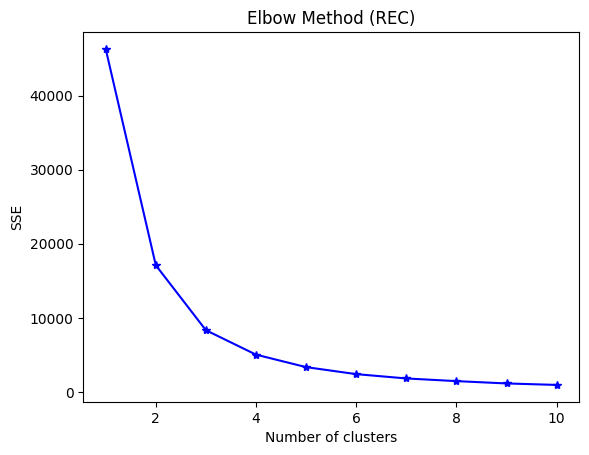

In [164]:
# K-Means Clustering
#k-means
sse=[]
scaler = StandardScaler() 
recency = order_till_2022jul_with_feature_engineering[['RECENCY_DAYS']].to_numpy()
X_scaled = scaler.fit_transform(recency) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (REC)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [165]:
# Build 2 Recency Clusters and add it to dataframe 
kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
#tempCustRec = tempCustRec.to_pandas()
kmeans.fit(order_till_2022jul_with_feature_engineering[['RECENCY_DAYS']])
order_till_2022jul_with_feature_engineering['CUST_REC_CLUSTER'] = kmeans.predict(order_till_2022jul_with_feature_engineering[['RECENCY_DAYS']])


#function for ordering cluster numbers

def order_cluster(cluster_field_name, target_field_name,data,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    data_new['index'] = data_new.index
    data_final = pd.merge(data,data_new[[cluster_field_name,'index']], on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name],axis=1)
    data_final = data_final.rename(columns={"index":cluster_field_name})

    return data_final

order_till_2022jul_with_feature_engineering = order_cluster('CUST_REC_CLUSTER', 'RECENCY_DAYS',order_till_2022jul_with_feature_engineering,False)
#see details of the clusters
order_till_2022jul_with_feature_engineering.groupby('CUST_REC_CLUSTER')['RECENCY_DAYS'].describe()


,count,mean,std,min,25%,50%,75%,max
CUST_REC_CLUSTER,,,,,,,,
0,9017.0,35.529999,14.656380,22.0,25.0,31.0,41.0,195.0
1,37283.0,7.970818,5.889908,1.0,3.0,6.0,12.0,21.0


##### RFM Clustering - Frequency

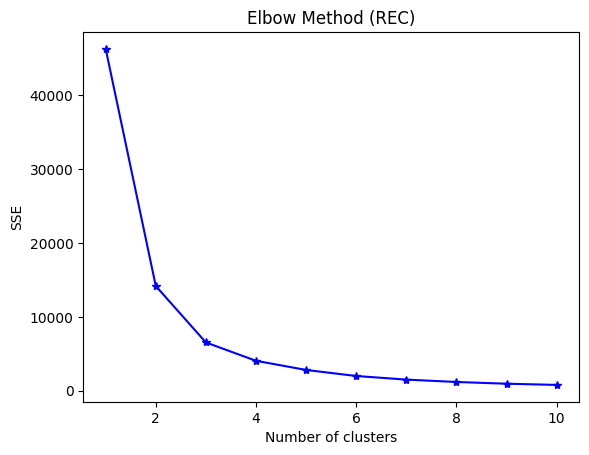

In [166]:
# K-Means Clustering
#k-means
sse=[]
scaler = StandardScaler() 
recency = order_till_2022jul_with_feature_engineering[['CUSTOMER_FREQUENCY']].to_numpy()
X_scaled = scaler.fit_transform(recency) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (REC)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [167]:
#build 2 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters=3, n_init=20, random_state=1)
kmeans.fit(order_till_2022jul_with_feature_engineering[['CUSTOMER_FREQUENCY']])
order_till_2022jul_with_feature_engineering['CUST_FREQ_CLUSTER'] = kmeans.predict(order_till_2022jul_with_feature_engineering[['CUSTOMER_FREQUENCY']])


# reuse function for ordering cluster numbers
rfm_df = order_cluster('CUST_FREQ_CLUSTER', 'CUSTOMER_FREQUENCY',order_till_2022jul_with_feature_engineering,True)
#see details of the clusters
order_till_2022jul_with_feature_engineering.groupby('CUST_FREQ_CLUSTER')['CUSTOMER_FREQUENCY'].describe()

,count,unique,top,freq
CUST_FREQ_CLUSTER,,,,
0,19984,5249,22.121211,53
1,15689,4343,22.473460,41
2,10627,5385,11.774194,14


##### RFM Clustering - Monetary

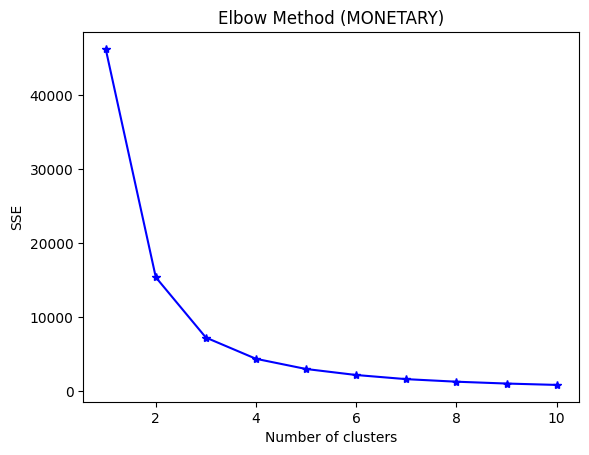

In [168]:
#k-means
sse=[]
scaler = StandardScaler() 
monetary = order_till_2022jul_with_feature_engineering[['MONETARY_VALUE']]
X_scaled = scaler.fit_transform(monetary) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (MONETARY)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [169]:
#build 2 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
kmeans.fit(order_till_2022jul_with_feature_engineering[['MONETARY_VALUE']])
order_till_2022jul_with_feature_engineering['CUST_MONETARY_CLUSTER'] = kmeans.predict(order_till_2022jul_with_feature_engineering[['MONETARY_VALUE']])


# reuse function for ordering cluster numbers
order_till_2022jul_with_feature_engineering = order_cluster('CUST_MONETARY_CLUSTER', 'MONETARY_VALUE',order_till_2022jul_with_feature_engineering,True)
order_till_2022jul_with_feature_engineering.groupby("CUST_MONETARY_CLUSTER")["MONETARY_VALUE"].describe()

,count,unique,top,freq
CUST_MONETARY_CLUSTER,,,,
0,16433,16300,697.6370403008,3
1,29867,29231,893.5222732575,4


In [170]:
# Final Dataframe for orders till 2022 july
order_till_2022jul_with_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_ID            46300 non-null  int32  
 1   TOTAL_SPENT            46300 non-null  float64
 2   YEARS_WITH_US          46300 non-null  float64
 3   MONETARY_VALUE         46300 non-null  object 
 4   CUSTOMER_FREQUENCY     46300 non-null  object 
 5   TOTAL_ORDER            46300 non-null  int64  
 6   RECENCY_DAYS           46300 non-null  int32  
 7   CITY_FREQUENCY         46300 non-null  int64  
 8   ORDER_TOTAL_S1         46300 non-null  float64
 9   ORDER_TOTAL_S2         46300 non-null  float64
 10  ORDER_TOTAL_S3         46300 non-null  float64
 11  CHANGE_FROM_S1_TO_S2   46300 non-null  object 
 12  CHANGE_FROM_S2_TO_S3   46300 non-null  object 
 13  CUST_REC_CLUSTER       46300 non-null  int64  
 14  CUST_FREQ_CLUSTER      46300 non-null  int32  
 15  CU

##### Create Target Variables

In [171]:
# Calculate overall score of customer based on their RFM
order_till_2022jul_with_feature_engineering['OVERALL_SCORE'] = order_till_2022jul_with_feature_engineering['CUST_REC_CLUSTER'] + order_till_2022jul_with_feature_engineering['CUST_FREQ_CLUSTER'] + order_till_2022jul_with_feature_engineering['CUST_MONETARY_CLUSTER']

# Evaluation
order_till_2022jul_with_feature_engineering.groupby('OVERALL_SCORE')[['RECENCY_DAYS','CUSTOMER_FREQUENCY','MONETARY_VALUE']].max()

,RECENCY_DAYS,CUSTOMER_FREQUENCY,MONETARY_VALUE
OVERALL_SCORE,,,
0,117,22.322958,718.6717283801
1,120,25.627664,1106.4689094108
2,195,31.739126,1358.7263343354
3,98,35.761445,1494.1568221246
4,21,16.413277,833.8332395153


In [172]:
# Creating Dataframe for Holdout Data
orders_holdout = order_header_df.filter(F.col("ORDER_TS").between('2022-08-01 00:00:00',('2022-11-01 23:59:59')))

# Check if timeframe in the dataset is correct
orders_holdout.agg(F.min("ORDER_TS")).show()
orders_holdout.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-08-01 08:00:00  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:59:59  |
-----------------------



In [173]:
# After filtering of customer dataset to only US, we will be filtering and looking at the orders 
# based on these customers only
customer_US = us_customer_df.select(F.col("CUSTOMER_ID"))
orders_holdout = orders_holdout.join(customer_US, orders_holdout.CUSTOMER_ID == customer_US.CUSTOMER_ID, lsuffix = "", rsuffix = "_US")

In [174]:
# Create target variable to evaluate model performace 
orders_holdout = orders_holdout.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("MONETARY_M3_HO"))
orders_holdout = orders_holdout.to_pandas()

# Merge with our dataframe
orders_holdout_final = pd.merge(order_till_2022jul_with_feature_engineering, orders_holdout, on="CUSTOMER_ID",how='left')

In [175]:
# Impute null values in target variable as 0
orders_holdout_final = orders_holdout_final.fillna(0)

# Check final_df
orders_holdout_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_ID            46300 non-null  int32  
 1   TOTAL_SPENT            46300 non-null  float64
 2   YEARS_WITH_US          46300 non-null  float64
 3   MONETARY_VALUE         46300 non-null  object 
 4   CUSTOMER_FREQUENCY     46300 non-null  object 
 5   TOTAL_ORDER            46300 non-null  int64  
 6   RECENCY_DAYS           46300 non-null  int32  
 7   CITY_FREQUENCY         46300 non-null  int64  
 8   ORDER_TOTAL_S1         46300 non-null  float64
 9   ORDER_TOTAL_S2         46300 non-null  float64
 10  ORDER_TOTAL_S3         46300 non-null  float64
 11  CHANGE_FROM_S1_TO_S2   46300 non-null  object 
 12  CHANGE_FROM_S2_TO_S3   46300 non-null  object 
 13  CUST_REC_CLUSTER       46300 non-null  int64  
 14  CUST_FREQ_CLUSTER      46300 non-null  int32  
 15  CU

In [176]:
# Create cluster
kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
kmeans.fit(orders_holdout_final[['MONETARY_M3_HO']])
orders_holdout_final['LTVCluster'] = kmeans.predict(orders_holdout_final[['MONETARY_M3_HO']])

#order cluster number based on LTV
orders_holdout_final = order_cluster('LTVCluster', 'MONETARY_M3_HO',orders_holdout_final,True)

#creatinga new cluster dataframe
df_cluster_holdout = orders_holdout_final.copy()

#see details of the clusters
df_cluster_holdout.groupby('LTVCluster')['MONETARY_M3_HO'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,27733.0,204.063570,69.935102,0.0,155.0,211.50,261.25,313.75
1,18567.0,424.102615,92.647769,314.0,352.5,401.25,471.75,1099.25


In [177]:
X_holdout = df_cluster_holdout.copy()
# Ensure that the columns are in same index
X_holdout = X_holdout.reindex(list(X_test.columns), axis=1)
X_holdout_ref = df_cluster_holdout[['CUSTOMER_ID','MONETARY_M3_HO','LTVCluster']]
y_holdout = df_cluster_holdout['LTVCluster']

# Create dataframe to store holdout accuracy
modelHoldoutResults = pd.DataFrame(columns=['Model', 'Holdout_Accuracy'])

In [178]:
for i in X_holdout.columns:
    try:
        X_holdout[[i]] = X_holdout[[i]].astype(float)
    except:
        pass

#### Logistic Regression

In [179]:
trainAcc = LRModel.score(X_holdout,y_holdout)
print('testing accuracy is: ', LRModel.score(X_holdout,y_holdout))

new_row = {'Model' : 'Logistic Regression','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.6660907127429806


#### XG Boost

In [180]:
trainAcc = xgbModel.score(X_holdout,y_holdout)
print('testing accuracy is: ', xgbModel.score(X_holdout,y_holdout))

new_row = {'Model' : 'XGBoost','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.6669330453563715


#### KNN Classifier

In [181]:
trainAcc= knnModel.score(X_holdout,y_holdout)
print('testing accuracy is: ', knnModel.score(X_holdout,y_holdout))

new_row = {'Model' : 'K-Nearest Neighbors','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.6436285097192225


#### Decision Tree

In [182]:
trainAcc = dtModel.score(X_holdout,y_holdout)
print('testing accuracy is: ', dtModel.score(X_holdout,y_holdout))

new_row = {'Model' : 'Decision Tree (depth=5)','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.6654859611231102


#### Random Forest

In [183]:
trainAcc = rfModel.score(X_holdout,y_holdout)
print('testing accuracy is: ', rfModel.score(X_holdout,y_holdout))

new_row = {'Model' : 'Random Forest','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.6671490280777538


#### ADA Boost

In [184]:
trainAcc = adaModel.score(X_holdout,y_holdout)
print('testing accuracy is: ', adaModel.score(X_holdout,y_holdout))

new_row = {'Model' : 'AdaBoost','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.6729373650107991


#### MLP

In [185]:
trainAcc = mlp.score(X_holdout,y_holdout)
print('testing accuracy is: ', mlp.score(X_holdout,y_holdout))

new_row = {'Model' : 'Multi-layer Perceptron','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.638963282937365


#### Decision Tree (GS)

In [186]:
trainAcc = dtModel_GV.score(X_holdout,y_holdout)
print('testing accuracy is: ', dtModel_GV.score(X_holdout,y_holdout))

new_row = {'Model' : 'Decision Tree (GS)','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.6572354211663067


#### MLP (GS)

In [187]:
trainAcc = mlp_GV.score(X_holdout,y_holdout)
print('testing accuracy is: ', mlp_GV.score(X_holdout,y_holdout))

new_row = {'Model' : 'MLP (GS)','Holdout_Accuracy': trainAcc}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

testing accuracy is:  0.5989848812095032


In [188]:
# Hold Out Model Results
modelHoldoutResults

,Model,Holdout_Accuracy
0,Logistic Regression,0.666091
1,XGBoost,0.666933
2,K-Nearest Neighbors,0.643629
3,Decision Tree (depth=5),0.665486
4,Random Forest,0.667149
5,AdaBoost,0.672937
6,Multi-layer Perceptron,0.638963
7,Decision Tree (GS),0.657235
8,MLP (GS),0.598985


### 6.4 Comparison of Results (Testing and Holdout Data) <a id="part6-4"></a>

In [189]:
model_results_final = pd.merge(modelTestResults,modelHoldoutResults, how='left',on='Model')
model_results_final

,Model,Train_Accuracy,Test_Accuracy,Cross_Val_Train_Accuracy,Cross_Val_Test_Accuracy,Holdout_Accuracy
0,XGBoost,0.788954,0.675810,0.793337,0.581598,0.666933
1,K-Nearest Neighbors,0.761370,0.643988,0.764573,0.608488,0.643629
2,Decision Tree (depth=5),0.678402,0.667027,0.689487,0.575680,0.665486
3,Random Forest,1.000000,0.677106,0.999989,0.582397,0.667149
4,AdaBoost,0.692934,0.682505,0.701479,0.596285,0.672937
5,Multi-layer Perceptron,0.659056,0.654644,0.634131,0.548488,0.638963
6,Decision Tree (GS),0.672293,0.670698,0.679519,0.608207,0.657235
7,MLP (GS),0.610151,0.607847,0.609471,0.609460,0.598985


Based on the accuracies above, the final model we picked is Decision Tree (GS), AdaBoost. As it shows the least sign of overfitting and underfitting as well as positive uplift. 

### 6.5 Measurement of Uplift <a id="part6-5"></a>

In [190]:
model_uplift = pd.DataFrame(columns=['Model','Total Uplift', 'Uplift (%)'])
model_uplift

,Model,Total Uplift,Uplift (%)


In [213]:
# Obtain mean sales value for each cluster
predictedSales = df_cluster_holdout.groupby('LTVCluster')['MONETARY_M3_HO'].mean()
predictedSales[0], predictedSales[1]

(204.06357047560667, 424.1026148543114)

In [214]:
predictedSales = [[predictedSales[0], predictedSales[1]]]
predictedSales

[[204.06357047560667, 424.1026148543114]]

In [216]:
# Create a DataFrame from the list
predictedSales = pd.DataFrame(predictedSales, columns=['Cluster0MeanSales', 'Cluster1MeanSales'])
# Save DataFrame to CSV file
predictedSales.to_csv('clusterSales[3M].csv', index=False, encoding='utf-8')

In [192]:
# Function for calculation of uplift (total and percent)
def model_predict_proba(model, X_holdout, df_cluster_holdout, predictedSales):
    # Inputs for model, X holdout dataframe, cluster holdout dataframe (target), mean sales for each cluster 
    y_predict_ho_prob = model.predict_proba(X_holdout)
    predicted_proba = pd.DataFrame(y_predict_ho_prob, columns = ['PREDICTED_PROBA_0','PREDICTED_PROBA_1'],index=X_holdout.index.tolist())
    predicted_proba = pd.merge(df_cluster_holdout[['CUSTOMER_ID','LTVCluster','MONETARY_M3_HO']],predicted_proba, left_index=True, right_index=True)
    
    # Calculation for predicted sales using class 1 probability
    predicted_proba["PREDICT_SALES"] = (predicted_proba['PREDICTED_PROBA_0'] * predictedSales[0]) + (predicted_proba['PREDICTED_PROBA_1'] * predictedSales[1])
    
    # Calculation of uplife
    totalUplift = predicted_proba['PREDICT_SALES'].sum() - predicted_proba['MONETARY_M3_HO'].sum()
    
    # Calculation for change in revenue
    percentUplift = ((predicted_proba['PREDICT_SALES'].sum() -  predicted_proba['MONETARY_M3_HO'].sum()) / predicted_proba['MONETARY_M3_HO'].sum()) * 100
    
    return totalUplift, percentUplift

XGBoost Uplift Result

In [193]:
# Displaying XGBoost Uplift Result
display(model_predict_proba(xgbModel, X_holdout, df_cluster_holdout, predictedSales))

new_row = {'Model':'XGBoost', 'Total Uplift':model_predict_proba(xgbModel, X_holdout, df_cluster_holdout, predictedSales)[0], 
           'Uplift (%)':model_predict_proba(xgbModel, X_holdout, df_cluster_holdout, predictedSales)[1]}
model_uplift = model_uplift.append(new_row, ignore_index=True)

(-781175.25, -5.772113656385761)

In [194]:
model_uplift

,Model,Total Uplift,Uplift (%)
0,XGBoost,-781175.25,-5.772114


K-Nearest Neighbors Uplift Result

In [195]:
# Displaying K-Nearest Neighbors Uplift Result
display(model_predict_proba(knnModel, X_holdout, df_cluster_holdout, predictedSales))

new_row = {'Model':'K-Nearest Neighbors', 'Total Uplift':model_predict_proba(knnModel, X_holdout, df_cluster_holdout, predictedSales)[0], 
           'Uplift (%)':model_predict_proba(knnModel, X_holdout, df_cluster_holdout, predictedSales)[1]}
model_uplift = model_uplift.append(new_row, ignore_index=True)

(-590056.7014059313, -4.359936319317734)

Decision Tree (depth=5) Uplift Result

In [196]:
# Displaying Decision Tree (depth=5) Uplift Result
display(model_predict_proba(dtModel, X_holdout, df_cluster_holdout, predictedSales))

new_row = {'Model':'Decision Tree (depth=5)', 'Total Uplift':model_predict_proba(dtModel, X_holdout, df_cluster_holdout, predictedSales)[0], 
           'Uplift (%)':model_predict_proba(dtModel, X_holdout, df_cluster_holdout, predictedSales)[1]}
model_uplift = model_uplift.append(new_row, ignore_index=True)

(-389245.3603000399, -2.8761388175990676)

Random Forest Uplift Model

In [197]:
# Displaying Random Forest Uplift Result
display(model_predict_proba(rfModel, X_holdout, df_cluster_holdout, predictedSales))

new_row = {'Model':'Random Forest', 'Total Uplift':model_predict_proba(rfModel, X_holdout, df_cluster_holdout, predictedSales)[0], 
           'Uplift (%)':model_predict_proba(rfModel, X_holdout, df_cluster_holdout, predictedSales)[1]}
model_uplift = model_uplift.append(new_row, ignore_index=True)

(-287641.6399831753, -2.125387662105376)

AdaBoost Uplift Model

In [198]:
# Displaying AdaBoost Uplift Result
display(model_predict_proba(adaModel, X_holdout, df_cluster_holdout, predictedSales))

new_row = {'Model':'AdaBoost', 'Total Uplift':model_predict_proba(adaModel, X_holdout, df_cluster_holdout, predictedSales)[0], 
           'Uplift (%)':model_predict_proba(adaModel, X_holdout, df_cluster_holdout, predictedSales)[1]}
model_uplift = model_uplift.append(new_row, ignore_index=True)

(957852.9069342501, 7.077587065033082)

Multi-layer Perceptron Uplift Model

In [199]:
# Displaying Multi-layer Perceptron Uplift Result
display(model_predict_proba(mlp, X_holdout, df_cluster_holdout, predictedSales))

new_row = {'Model':'Multi-layer Perceptron', 'Total Uplift':model_predict_proba(mlp, X_holdout, df_cluster_holdout, predictedSales)[0], 
           'Uplift (%)':model_predict_proba(mlp, X_holdout, df_cluster_holdout, predictedSales)[1]}
model_uplift = model_uplift.append(new_row, ignore_index=True)

(-768051.2516532838, -5.675140269065228)

Decision Tree (GS) Uplift Model

In [200]:
# Displaying Decision Tree (GS) Uplift Result
display(model_predict_proba(dtModel_GV, X_holdout, df_cluster_holdout, predictedSales))

new_row = {'Model':'Decision Tree (GS)', 'Total Uplift':model_predict_proba(dtModel_GV, X_holdout, df_cluster_holdout, predictedSales)[0], 
           'Uplift (%)':model_predict_proba(dtModel_GV, X_holdout, df_cluster_holdout, predictedSales)[1]}
model_uplift = model_uplift.append(new_row, ignore_index=True)

(-295481.9270979017, -2.183319641293014)

MLP (GS) Uplift Model

In [201]:
# Displaying MLP (GS) Uplift Result
display(model_predict_proba(mlp_GV, X_holdout, df_cluster_holdout, predictedSales))

new_row = {'Model':'MLP (GS)', 'Total Uplift':model_predict_proba(mlp_GV, X_holdout, df_cluster_holdout, predictedSales)[0], 
           'Uplift (%)':model_predict_proba(mlp_GV, X_holdout, df_cluster_holdout, predictedSales)[1]}
model_uplift = model_uplift.append(new_row, ignore_index=True)

(-126713.45737548918, -0.9362873155094406)

In [202]:
# Display Uplift
model_uplift

,Model,Total Uplift,Uplift (%)
0,XGBoost,-781175.250000,-5.772114
1,K-Nearest Neighbors,-590056.701406,-4.359936
2,Decision Tree (depth=5),-389245.360300,-2.876139
3,Random Forest,-287641.639983,-2.125388
4,AdaBoost,957852.906934,7.077587
5,Multi-layer Perceptron,-768051.251653,-5.675140
6,Decision Tree (GS),-295481.927098,-2.183320
7,MLP (GS),-126713.457375,-0.936287


In [203]:
model_results_final = pd.merge(model_results_final, model_uplift, on="Model",how='left')
model_results_final

,Model,Train_Accuracy,Test_Accuracy,Cross_Val_Train_Accuracy,Cross_Val_Test_Accuracy,Holdout_Accuracy,Total Uplift,Uplift (%)
0,XGBoost,0.788954,0.675810,0.793337,0.581598,0.666933,-781175.250000,-5.772114
1,K-Nearest Neighbors,0.761370,0.643988,0.764573,0.608488,0.643629,-590056.701406,-4.359936
2,Decision Tree (depth=5),0.678402,0.667027,0.689487,0.575680,0.665486,-389245.360300,-2.876139
3,Random Forest,1.000000,0.677106,0.999989,0.582397,0.667149,-287641.639983,-2.125388
4,AdaBoost,0.692934,0.682505,0.701479,0.596285,0.672937,957852.906934,7.077587
5,Multi-layer Perceptron,0.659056,0.654644,0.634131,0.548488,0.638963,-768051.251653,-5.675140
6,Decision Tree (GS),0.672293,0.670698,0.679519,0.608207,0.657235,-295481.927098,-2.183320
7,MLP (GS),0.610151,0.607847,0.609471,0.609460,0.598985,-126713.457375,-0.936287


In [204]:
# Round accuracy to 3 decimal place
model_results_final.round(3)

,Model,Train_Accuracy,Test_Accuracy,Cross_Val_Train_Accuracy,Cross_Val_Test_Accuracy,Holdout_Accuracy,Total Uplift,Uplift (%)
0,XGBoost,0.789,0.676,0.793,0.582,0.667,-781175.250,-5.772
1,K-Nearest Neighbors,0.761,0.644,0.765,0.608,0.644,-590056.701,-4.360
2,Decision Tree (depth=5),0.678,0.667,0.689,0.576,0.665,-389245.360,-2.876
3,Random Forest,1.000,0.677,1.000,0.582,0.667,-287641.640,-2.125
4,AdaBoost,0.693,0.683,0.701,0.596,0.673,957852.907,7.078
5,Multi-layer Perceptron,0.659,0.655,0.634,0.548,0.639,-768051.252,-5.675
6,Decision Tree (GS),0.672,0.671,0.680,0.608,0.657,-295481.927,-2.183
7,MLP (GS),0.610,0.608,0.609,0.609,0.599,-126713.457,-0.936


The table shown above shows the model comparison between  `Predicted Sales` and `Actual Sales`that US customers will generate in the next month. From the table, it suggest that there is an uplift in sales for two models.

As Adaboost has the highest uplift percentage, therefore we will be using it

### 7. Final Model 

In [205]:
def exportPredictionAsCsv(ChoosenModel, X_holdout, df_cluster_holdout, predictedSales):
    # Inputs for model, X holdout dataframe, cluster holdout dataframe (target), mean sales for each cluster 
    y_predict_ho_prob = ChoosenModel.predict_proba(X_holdout)
    predicted_proba = pd.DataFrame(y_predict_ho_prob, columns = ['PREDICTED_PROBA_0','PREDICTED_PROBA_1'],index=X_holdout.index.tolist())
    predicted_proba = pd.merge(df_cluster_holdout[['CUSTOMER_ID','LTVCluster','MONETARY_M3_HO']],predicted_proba, left_index=True, right_index=True)
    
    # Calculation for predicted sales using class 1 probability
    predicted_proba["PREDICT_SALES"] = (predicted_proba['PREDICTED_PROBA_0'] * predictedSales[0]) + (predicted_proba['PREDICTED_PROBA_1'] * predictedSales[1])
    predicted_proba_result = predicted_proba.merge(X_holdout, left_index=True, right_index=True, how='inner')
    predicted_proba_result.to_csv('UpliftPrediction[3M].csv')
    return

In [206]:
# Exporting choosen model prediction as a csv
exportPredictionAsCsv(adaModel, X_holdout, df_cluster_holdout, predictedSales)

In [207]:
import pickle
pickle.dump(adaModel, open('Uplift_3M.pkl','wb'))